In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold, output, info
from utilities.info import *

In [2]:
print("FILES:\t", FILE_DIR)
print("RESULT:\t", RESULTS_DIR)
print("FIGS:\t", FIG_DIR)
print("TABLES:\t", TAB_DIR)

FILES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/files
RESULT:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/results
FIGS:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/thesis-figs
TABLES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/thesis-tables


In [3]:
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']
TABLE_SCORE_PRECISION = 2
MIN_MAL = 15
TOP_N_CONFOUNDERS = 10

In [4]:
nlst_preds_nodule = pd.read_csv(f"{FILE_DIR}/nlst_allmodels_demos.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 127 entries, PatientID to study
dtypes: bool(27), float64(85), int64(11), object(4)
memory usage: 12.7+ MB


In [5]:
with open(f'{FILE_DIR}/nlst_democols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['height', 'weight', 'BMI', 'Age'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'nodule': ['CoordX', 'CoordY', 'CoordZ'],
  'other': ['Diameter_mm', 'NoduleCounts']},
 'cat': {'demo': ['race',
   'NonHispanicWhite',
   'HighSchoolPlus',
   'Unfinished_ed',
   'marital',
   'ethnic',
   'Married',
   'Overweight',
   'WhiteOrBlack',
   'educat',
   'Gender'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop

# Materials

## Demographic characteristics of the NLST validation sets (n=5911 scans, n=1172 scans).

In [6]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [7]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [8]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
    "Partial (malignant)": nlstval_some_mal,
    "Partial (benign)": nlstval_some_ben,
    # "Partial (all)": nlst_1172,
}

In [9]:
cat_df0 = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
cat_df = cat_df0.copy(deep=True)
for s in validation_sets:
    cat_df[f"{s}_info"] = cat_df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_df = cat_df[['category', 'attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))[[f"{s}_info" for s in validation_sets]]

In [10]:

attribute_valid_subgroups_1172 = cat_df0[cat_df0['Partial (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_1172 = list(attribute_valid_subgroups_1172[attribute_valid_subgroups_1172 < 2].index)

attribute_valid_subgroups_5911 = cat_df0[cat_df0['Full (malignant)_freq'] > 15][['attribute', 'value', 'Full (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_5911 = list(attribute_valid_subgroups_5911[attribute_valid_subgroups_5911 < 2].index)

total_categorical_columns = cat_df0['attribute'].nunique()
print("invalid:", len(invalid_attributes_5911), len(invalid_attributes_1172))
print("valid:", total_categorical_columns - len(invalid_attributes_5911), total_categorical_columns - len(invalid_attributes_1172))

invalid: 36 59
valid: 47 24


In [11]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[(num_df['value'].isin(['Median (IQR)']))][['category', 'attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))[[f"{s}" for s in validation_sets]]

In [12]:
multicol_idx = pd.MultiIndex.from_tuples([
    ('Full Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('Full Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('Full Dataset (n=5911 Scans)', 'Total'),
    ('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)'),
    ('Partial Dataset (n=1172 Scans)', 'Benign (n=1045)'),
    # ('Partial Dataset (n=1172 Scans)', 'Total'),
])

cat_df.columns = multicol_idx
num_df.columns = multicol_idx

In [13]:
df_out = pd.concat([cat_df, num_df], axis=0)
df_out

Full Dataset (n=5911 Scans)  \
                                                                 Malignant (n=581)   
category     attribute              value                                            
Demographics Race                   Asian                                  6 (1.0)   
                                    Black                                 28 (4.8)   
                                    More than one race                     6 (1.0)   
                                    Native American                        8 (1.4)   
                                    Native Hawaiian                        1 (0.2)   
...                                                                            ...   
Smoking      Age at Smoking Onset   Median (IQR)                            16 (4)   
             Cigarettes per Day     Median (IQR)                           30 (20)   
             Total Years of Smoking Median (IQR)                           44 (10)   
Other        Diameter (mm)          Median (IQR)                            12 (9)   
             Nodules Per Scan       Median (IQR)                             2 (2)   

                                                                        \
                                                       Benign (n=5330)   
category     attribute              value                                
Demographics Race                   Asian                     66 (1.2)   
                                    Black                    160 (3.0)   
                                    More than one race        59 (1.1)   
                                    Native American           15 (0.3)   
                                    Native Hawaiian           17 (0.3)   
...                                                                ...   
Smoking      Age at Smoking Onset   Median (IQR)                16 (3)   
             Cigarettes per Day     Median (IQR)               25 (15)   
             Total Years of Smoking Median (IQR)               41 (10)   
Other        Diameter (mm)          Median (IQR)                 6 (4)   
             Nodules Per Scan       Median (IQR)                 1 (1)   

                                                       Partial Dataset (n=1172 Scans)  \
                                                                    Malignant (n=127)   
category     attribute              value                                               
Demographics Race                   Asian                                     0 (0.0)   
                                    Black                                     9 (7.1)   
                                    More than one race                        0 (0.0)   
                                    Native American                           5 (3.9)   
                                    Native Hawaiian                           1 (0.8)   
...                                                                               ...   
Smoking      Age at Smoking Onset   Median (IQR)                               16 (4)   
             Cigarettes per Day     Median (IQR)                              30 (20)   
             Total Years of Smoking Median (IQR)                              44 (10)   
Other        Diameter (mm)          Median (IQR)                               11 (9)   
             Nodules Per Scan       Median (IQR)                                2 (1)   

                                                                        
                                                       Benign (n=1045)  
category     attribute              value                               
Demographics Race                   Asian                      7 (0.7)  
                                    Black                     31 (3.0)  
                                    More than one race        11 (1.1)  
                                    Native American            5 (0.5)  
                                    Native Hawaiian    

In [159]:
df_other = df_out[df_out.index.isin(['Nodule', 'Smoking', 'Work History', 'Disease Diagnosis', 'Lung Cancer', 'Other'], level='category')].sort_index()
len(df_other)

125

In [165]:
df_other[~df_other.index.isin([False], level='value')].droplevel(level='value').style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
        buf=f"{TAB_DIR}/extra-results/nlst-splits-NonDemo.tex",
        hrules=True, label=f'tab:nlstSplitsNonDemo', environment='table*', column_format='ll|rr|rr', position='htbp!',
        multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
        caption=f'Non-demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). For categorical characteristics, the number is included with a percentage in parentheses. For numerical characteristics, the median is included with interquartile range in parentheses.')

In [173]:
df_out.xs('Lung Cancer', level='category')

Full Dataset (n=5911 Scans)  \
                                              Malignant (n=581)   
attribute                     value                               
Small Cell Carcinoma          False                  559 (96.2)   
                              True                     22 (3.8)   
Squamous Cell Carcinoma       False                  461 (79.3)   
                              True                   120 (20.7)   
Adenocarcinoma                False                  348 (59.9)   
                              True                   233 (40.1)   
Bronchiolo-Alveolar Carcinoma False                  483 (83.1)   
                              True                    98 (16.9)   
Large Cell Carcinoma          False                  562 (96.7)   
                              True                     19 (3.3)   
Adenosquamous Carcinoma       False                  575 (99.0)   
                              True                      6 (1.0)   
Carcinoid Tumor               False                  575 (99.0)   
                              True                      6 (1.0)   
Unclassified Carcinoma        False                  510 (87.8)   
                              True                    71 (12.2)   
LC Stage                      IA                     295 (50.8)   
                              IB                      61 (10.5)   
                              IIA                      40 (6.9)   
                              IIB                      16 (2.8)   
                              IIIA                    60 (10.3)   
                              IIIB                     20 (3.4)   
                              IV                      74 (12.7)   

                                                     \
                                    Benign (n=5330)   
attribute                     value                   
Small Cell Carcinoma          False    5330 (100.0)   
                              True          0 (0.0)   
Squamous Cell Carcinoma       False    5330 (100.0)   
                              True          0 (0.0)   
Adenocarcinoma                False    5330 (100.0)   
                              True          0 (0.0)   
Bronchiolo-Alveolar Carcinoma False    5330 (100.0)   
                              True          0 (0.0)   
Large Cell Carcinoma          False    5330 (100.0)   
                              True          0 (0.0)   
Adenosquamous Carcinoma       False    5330 (100.0)   
                              True          0 (0.0)   
Carcinoid Tumor               False    5330 (100.0)   
                              True          0 (0.0)   
Unclassified Carcinoma        False    5330 (100.0)   
                              True          0 (0.0)   
LC Stage                      IA            0 (0.0)   
                              IB            0 (0.0)   
                              IIA           0 (0.0)   
                              IIB           0 (0.0)   
                              IIIA          0 (0.0)   
                              IIIB          0 (0.0)   
                              IV            0 (0.0)   

                                    Partial Dataset (n=1172 Scans)  \
                                                 Malignant (n=127)   
attribute                     value                                  
Small Cell Carcinoma          False                     123 (96.9)   
                              True                         4 (3.1)   
Squamous Cell Carcinoma       False                     103 (81.1)   
                              True                       24 (18.9)   
Adenocarcinoma                False                      70 (55.1)   
                              True                       57 (44.9)   
Bronchiolo-Alveolar Carcinoma False                     119 (93.7)   
                              True                         8 (6.3)   
Large Cell Carcinoma          False                     123 (96.9)   
                      

In [172]:
df_out2 = df_out.xs('Demographics', level='category')
df_out2

Full Dataset (n=5911 Scans)  \
                                                   Malignant (n=581)   
attribute            value                                             
Race                 Asian                                   6 (1.0)   
                     Black                                  28 (4.8)   
                     More than one race                      6 (1.0)   
                     Native American                         8 (1.4)   
                     Native Hawaiian                         1 (0.2)   
                     White                                530 (91.2)   
Non-Hispanic White   False                                  55 (9.5)   
                     True                                 526 (90.5)   
HS Education         False                                   9 (1.5)   
                     True                                 572 (98.5)   
Unfinished Education False                                423 (72.8)   
                     True                                 158 (27.2)   
Marital Status       Divorced                             125 (21.5)   
                     Married                              384 (66.1)   
                     Never Married                          16 (2.8)   
                     Separated                               5 (0.9)   
                     Widowed                                49 (8.4)   
Ethnicity            Hispanic/Latino                         4 (0.7)   
                     Not Hispanic/Latino                  574 (98.8)   
Married              False                                197 (33.9)   
                     True                                 384 (66.1)   
BMI                  < 25                                 209 (36.0)   
                     ≥ 25                                 372 (64.0)   
White or Black       Black                                  28 (4.8)   
                     White                                530 (91.2)   
Education Status     8th grade or less                       9 (1.5)   
                     9th-11th grade                         32 (5.5)   
                     Associate Degree                     126 (21.7)   
                     Bachelors Degree                      96 (16.5)   
                     Graduate School                       76 (13.1)   
                     HS Graduate / GED                    141 (24.3)   
                     Post-HS training                      87 (15.0)   
Sex                  Female                               244 (42.0)   
                     Male                                 337 (58.0)   
Height               Median (IQR)                             68 (6)   
Weight               Median (IQR)                           175 (50)   
Body Mass Index      Median (IQR)                             26 (4)   
Age                  Median (IQR)                             64 (8)   

                                                          \
                                         Benign (n=5330)   
attribute            value                                 
Race                 Asian                      66 (1.2)   
                     Black                     160 (3.0)   
                     More than one race         59 (1.1)   
                     Native American            15 (0.3)   
                     Native Hawaiian            17 (0.3)   
                     White                   4993 (93.7)   
Non-Hispanic White   False                     426 (8.0)   
                     True                    4904 (92.0)   
HS Education         False                     102 (1.9)   
                     True                    5228 (98.1)   
Unfinished Education False                   3897 (73.1)   
                     True                    1433 (26.9)   
Marital Status       Divorced                 998 (18.7)   
                     Married                 3590 (67.4)   
                     Never Married             213 (4.0)   
        

In [15]:
print(df_out2.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). HS = High School.'))

None


## DLCST vs. NLST

In [16]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
dlcst_preds = pd.read_csv(f"{FILE_DIR}/dlcst_allmodels_cal.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, DLCST_DEMOCOLS)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [113]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [114]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    # (num_popshift['category'] == "Demographics") & 
    (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [115]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Sex                  Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   
Nodules Per Scan     Median (IQR)                          2 (2)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Sex                  Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   
Nodules Per Scan     Median (IQR)           1 (1)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Sex                  Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   
Nodules Per Scan     Median (IQR)                          1 (1)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Sex                  Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)  
Nodules Per Scan     Median (IQR)          1 (1)

In [116]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [21]:
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=output.DLCST_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

In [22]:
nlst_1172, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
nlst_1172_policies, _ = threshold.get_threshold_policies(nlst_1172, models=output.NLST_1172_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [23]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=output.NLST_5911_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [24]:
policy_dfs = {
    "DLCST (n=599)": dlcst_policies.copy(deep=True), 
    "NLST Partial (n=1172)": nlst_1172_policies.copy(deep=True), 
    "NLST Full (n=5911)": nlst_5911_policies.copy(deep=True)
}

for val in policy_dfs:
    if 'Brock' in policy_dfs[val].columns:
        policy_dfs[val].drop(columns='Brock', inplace=True)
    policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
combined_policies = combined_policies[combined_policies.index != 'De Haas Global (Shown Nodule)']
combined_policies

DLCST (n=599)                  NLST Partial (n=1172)  \
                 90\% Sensitivity 90\% Specificity      90\% Sensitivity   
Venkadesh21                 0.134            0.204                 0.027   
Sybil (Year 1)              0.001            0.018                 0.003   
PanCan2b                    0.020            0.093                 0.014   
De Haas Local                 NaN              NaN                 0.050   
De Haas Global                NaN              NaN                 0.060   
De Haas Combined            0.099            0.193                 0.069   

                                  NLST Full (n=5911)                   
                 90\% Specificity   90\% Sensitivity 90\% Specificity  
Venkadesh21                 0.232              0.049            0.222  
Sybil (Year 1)              0.058              0.003            0.058  
PanCan2b                    0.168              0.015            0.165  
De Haas Local               0.228              0.045            0.226  
De Haas Global              0.257              0.066            0.265  
De Haas Combined            0.261                NaN              NaN

In [25]:
print(combined_policies.style.format(precision=3, na_rep='\\verb|-|').to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on DLCST and both NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \cite{Lim2020-ilst}.'))

None


# Results

## ROC Tables

### DLCST

In [26]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'de Haas', 'Sybil year 1', 'PanCan2b']
dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_11132\2578401092.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh21         De Haas Combined        \
                              AUROC     p              AUROC     p   
Attribute Group                                                      
Age       > 61    0.92 (0.87, 0.97)  None  0.91 (0.85, 0.96)  None   
          ≤ 61    0.92 (0.85, 0.97)   .99  0.92 (0.86, 0.97)   .78   
Sex       Male    0.91 (0.84, 0.96)  None  0.90 (0.84, 0.96)  None   
          Female  0.94 (0.91, 0.97)   .44  0.95 (0.91, 0.98)   .37   

                     Sybil (Year 1)                 PanCan2b        
                              AUROC     p              AUROC     p  
Attribute Group                                                     
Age       > 61    0.86 (0.78, 0.94)  None  0.85 (0.79, 0.91)  None  
          ≤ 61    0.86 (0.78, 0.93)   .98  0.90 (0.84, 0.95)   .46  
Sex       Male    0.87 (0.78, 0.94)  None  0.91 (0.86, 0.95)  None  
          Female  0.86 (0.78, 0.93)   .88  0.86 (0.79, 0.92)   .35

In [27]:
print(dlcst_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% CIs for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values .'))

None


In [167]:
dlcst_out_other = dlcst_out.xs("Other", level='Category')

print(dlcst_out_other.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/extra-results/resDLCSTotherROC.tex",
    hrules=True, label='tab:resDLCSTotherROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% CIs for models on other characteristics when evaluated on the DLCST validation set (599 scans), including p values.'))

dlcst_out_other

None


Venkadesh21         De Haas Combined        \
                                        AUROC     p              AUROC     p   
Attribute            Group                                                     
Emphysema in Scan    True   0.91 (0.86, 0.95)  None  0.91 (0.86, 0.96)  None   
                     False  0.97 (0.94, 0.99)   .17  0.95 (0.91, 0.98)   .44   
Family History of LC False  0.91 (0.85, 0.96)  None  0.91 (0.85, 0.95)  None   
                     True   0.95 (0.92, 0.99)   .37  0.97 (0.93, 1.00)   .18   
Nodules Per Scan     ≤ 1    0.93 (0.87, 0.97)  None  0.91 (0.86, 0.96)  None   
                     > 1    0.92 (0.88, 0.96)   .96  0.94 (0.89, 0.98)   .64   

                               Sybil (Year 1)                 PanCan2b        
                                        AUROC     p              AUROC     p  
Attribute            Group                                                    
Emphysema in Scan    True   0.86 (0.80, 0.92)  None  0.87 (0.81, 0.92)  None  
                     False  0.88 (0.80, 0.96)   .78  0.91 (0.87, 0.96)   .49  
Family History of LC False  0.86 (0.79, 0.92)  None  0.88 (0.83, 0.92)  None  
                     True   0.89 (0.80, 0.96)   .69  0.89 (0.82, 0.95)   .82  
Nodules Per Scan     ≤ 1    0.92 (0.87, 0.96)  None  0.90 (0.85, 0.94)  None  
                     > 1    0.78 (0.67, 0.89)   .03  0.87 (0.80, 0.93)   .63

### NLST (for Tijmen's combined model only.)

In [28]:
nlst_demos_to_include = ['Age', 'Sex', 'Race', 'HS Education', 'Height', 'Weight', 'BMI']
nlst_tijmen_model_order = ['de Haas Combined', 'de Haas Local', 'de Haas Global (hidden nodule)']

In [29]:
nlst_tijmen_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)

nlst_tijmen_scan_out = output.roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_tijmen_scan_out_demos = nlst_tijmen_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_1172')
nlst_tijmen_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_11132\104166115.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_tijmen_scan_out = output.roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


De Haas Combined            De Haas Local        \
                              AUROC     p              AUROC     p   
Attribute Group                                                      
Age       > 61    0.86 (0.82, 0.90)  None  0.85 (0.81, 0.90)  None   
          ≤ 61    0.88 (0.82, 0.92)   .73  0.88 (0.83, 0.93)   .45   
BMI       ≥ 25    0.87 (0.83, 0.90)  None  0.87 (0.83, 0.91)  None   
          < 25    0.87 (0.82, 0.92)   .91  0.85 (0.79, 0.90)   .57   
Height    > 68    0.87 (0.83, 0.91)  None  0.86 (0.82, 0.91)  None   
          ≤ 68    0.87 (0.82, 0.92)   .91  0.87 (0.83, 0.92)   .83   
Sex       Male    0.87 (0.84, 0.91)  None  0.87 (0.82, 0.91)  None   
          Female  0.86 (0.80, 0.91)   .69  0.87 (0.81, 0.91)   .98   
Weight    ≤ 180   0.86 (0.82, 0.90)  None  0.86 (0.82, 0.90)  None   
          > 180   0.87 (0.83, 0.91)   .83  0.87 (0.82, 0.92)   .71   

                     De Haas Global        
                              AUROC     p  
Attribute Group                            
Age       > 61    0.77 (0.73, 0.82)  None  
          ≤ 61    0.77 (0.71, 0.82)   .91  
BMI       ≥ 25    0.78 (0.74, 0.82)  None  
          < 25    0.75 (0.68, 0.81)   .49  
Height    > 68    0.79 (0.74, 0.84)  None  
          ≤ 68    0.75 (0.69, 0.81)   .39  
Sex       Male    0.80 (0.75, 0.84)  None  
          Female  0.72 (0.66, 0.78)   .13  
Weight    ≤ 180   0.74 (0.69, 0.79)  None  
          > 180   0.80 (0.75, 0.85)   .17

In [30]:
print(nlst_tijmen_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenROC.tex",
    hrules=True, label='tab:resNLSTtijmenROC', environment='table*', column_format=f'll{"|ll"*len(nlst_tijmen_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% CIs for the De Haas model and its constituent submodels on demographic characteristics when evaluated on the smaller NLST validation set (1172 scans), including p values. Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. No significant demographic biases were found from the De Haas Combined model on this limited set of scans.'))

None


### NLST for all other models

In [140]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = ['Venkadesh',    'de Haas Local', 'de Haas Global (hidden nodule)', 'Sybil year 1', 'PanCan2b']
nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_11132\1823227323.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh21            De Haas Local        \
                              AUROC     p              AUROC     p   
Attribute Group                                                      
Age       > 61    0.88 (0.86, 0.90)  None  0.86 (0.85, 0.88)  None   
          ≤ 61    0.90 (0.88, 0.92)   .14  0.88 (0.86, 0.91)   .33   
BMI       ≥ 25    0.90 (0.88, 0.91)  None  0.87 (0.85, 0.89)  None   
          < 25    0.88 (0.85, 0.90)   .32  0.87 (0.85, 0.90)   .91   
Height    ≤ 68    0.89 (0.87, 0.91)  None  0.88 (0.86, 0.90)  None   
          > 68    0.88 (0.86, 0.91)   .67  0.86 (0.84, 0.89)   .35   
Race      White   0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)  None   
          Black   0.82 (0.74, 0.89)   .14  0.81 (0.72, 0.89)   .21   
Sex       Male    0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)  None   
          Female  0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)   .40   
Weight    ≤ 180   0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)  None   
          > 180   0.89 (0.87, 0.91)   .65  0.87 (0.85, 0.89)   .95   

                     De Haas Global           Sybil (Year 1)          \
                              AUROC     p              AUROC       p   
Attribute Group                                                        
Age       > 61    0.79 (0.77, 0.81)  None  0.84 (0.82, 0.86)    None   
          ≤ 61    0.81 (0.79, 0.83)   .30  0.85 (0.82, 0.88)     .67   
BMI       ≥ 25    0.80 (0.78, 0.82)  None  0.86 (0.84, 0.88)    None   
          < 25    0.79 (0.76, 0.82)   .63  0.81 (0.78, 0.85)     .05   
Height    ≤ 68    0.79 (0.76, 0.81)  None  0.87 (0.85, 0.89)    None   
          > 68    0.80 (0.78, 0.83)   .48  0.80 (0.77, 0.83)  < .001   
Race      White   0.80 (0.78, 0.81)  None  0.84 (0.83, 0.86)    None   
          Black   0.83 (0.76, 0.90)   .45  0.83 (0.74, 0.90)     .77   
Sex       Male    0.81 (0.80, 0.83)  None  0.81 (0.78, 0.84)    None   
          Female  0.77 (0.74, 0.80)   .05  0.88 (0.86, 0.90)  < .001   
Weight    ≤ 180   0.78 (0.75, 0.80)  None  0.84 (0.82, 0.87)    None   
          > 180   0.82 (0.79, 0.84)   .05  0.84 (0.81, 0.87)     .82   

                           PanCan2b        
                              AUROC     p  
Attribute Group                            
Age       > 61    0.76 (0.74, 0.79)  None  
          ≤ 61    0.81 (0.78, 0.83)   .05  
BMI       ≥ 25    0.81 (0.79, 0.83)  None  
          < 25    0.73 (0.70, 0.77)  .001  
Height    ≤ 68    0.79 (0.76, 0.81)  None  
          > 68    0.78 (0.75, 0.80)   .71  
Race      White   0.78 (0.76, 0.80)  None  
          Black   0.75 (0.65, 0.83)   .54  
Sex       Male    0.79 (0.76, 0.81)  None  
          Female  0.78 (0.75, 0.81)   .66  
Weight    ≤ 180   0.77 (0.74, 0.79)  None  
          > 180   0.80 (0.77, 0.82)   .13

In [141]:
print(nlst_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% CIs for models on demographic characteristics when evaluated on the larger NLST validation set (5911 scans), including p values.'))

None


In [168]:
for category in data.rename_types.values():
    if category in ['Scanner', 'Demographics', 'Lung Cancer', 'Previous Cancer Diagnosis']:
        continue
    
    df_cat = nlst_scan_out.xs(category, level='Category')
    df_cat = df_cat.query('Attribute not in @invalid_attributes_5911')
    print(df_cat.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
        buf=f"{TAB_DIR}/extra-results/nlst-roc-{category}.tex",
        hrules=True, label=f'tab:nlst5911ROC-{category}', environment='sidewaystable*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='htbp!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
        caption=f'ROC AUC with 95\% CIs for models on {category} characteristics when evaluated on the larger NLST validation set (5911 scans), including p values.'))
    
    print(category)
    display(df_cat)

None
Smoking


Venkadesh21            De Haas Local  \
                                          AUROC     p              AUROC   
Attribute              Group                                               
Age at Smoking Onset   ≤ 16   0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)   
                       > 16   0.89 (0.87, 0.91)   .89  0.88 (0.85, 0.90)   
Cigarettes per Day     > 25   0.90 (0.89, 0.92)  None  0.89 (0.87, 0.91)   
                       ≤ 25   0.87 (0.85, 0.89)   .08  0.86 (0.84, 0.88)   
Current Smoker         True   0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)   
                       False  0.89 (0.88, 0.91)   .57  0.87 (0.85, 0.89)   
Lived w/ Smoker        True   0.89 (0.88, 0.91)  None  0.88 (0.86, 0.89)   
                       False  0.88 (0.83, 0.92)   .61  0.85 (0.79, 0.90)   
Pack-Years             > 55   0.90 (0.88, 0.91)  None  0.88 (0.86, 0.90)   
                       ≤ 55   0.88 (0.86, 0.90)   .37  0.87 (0.84, 0.89)   
Smoked Cigars          False  0.89 (0.88, 0.91)  None  0.88 (0.87, 0.90)   
                       True   0.87 (0.84, 0.90)   .40  0.82 (0.78, 0.87)   
Smoked Pipe            False  0.89 (0.87, 0.90)  None  0.88 (0.86, 0.89)   
                       True   0.90 (0.88, 0.92)   .49  0.86 (0.83, 0.90)   
Total Years of Smoking > 40   0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)   
                       ≤ 40   0.89 (0.87, 0.91)   .71  0.87 (0.85, 0.90)   
Worked w/ Smoker       True   0.89 (0.88, 0.91)  None  0.88 (0.86, 0.89)   
                       False  0.86 (0.81, 0.90)   .22  0.85 (0.79, 0.90)   

                                       De Haas Global        \
                                 p              AUROC     p   
Attribute              Group                                  
Age at Smoking Onset   ≤ 16   None  0.77 (0.75, 0.80)  None   
                       > 16    .74  0.83 (0.80, 0.85)   .01   
Cigarettes per Day     > 25   None  0.81 (0.79, 0.83)  None   
                       ≤ 25    .15  0.79 (0.76, 0.81)   .34   
Current Smoker         True   None  0.80 (0.77, 0.82)  None   
                       False   .95  0.80 (0.77, 0.82)   .98   
Lived w/ Smoker        True   None  0.80 (0.78, 0.81)  None   
                       False   .37  0.81 (0.76, 0.85)   .70   
Pack-Years             > 55   None  0.80 (0.77, 0.82)  None   
                       ≤ 55    .50  0.80 (0.78, 0.82)   .98   
Smoked Cigars          False  None  0.80 (0.78, 0.82)  None   
                       True    .02  0.78 (0.75, 0.82)   .55   
Smoked Pipe            False  None  0.80 (0.78, 0.82)  None   
                       True    .57  0.79 (0.76, 0.82)   .84   
Total Years of Smoking > 40   None  0.78 (0.75, 0.80)  None   
                       ≤ 40    .91  0.83 (0.80, 0.85)   .02   
Worked w/ Smoker       True   None  0.80 (0.78, 0.81)  None   
                       False   .34  0.80 (0.75, 0.84)   .94   

                                 Sybil (Year 1)                 PanCan2b        
                                          AUROC     p              AUROC     p  
Attribute              Group                                                    
Age at Smoking Onset   ≤ 16   0.84 (0.82, 0.86)  None  0.77 (0.74, 0.79)  None  
                       > 16   0.84 (0.81, 0.87)   .87  0.81 (0.78, 0.83)   .05  
Cigarettes per Day     > 25   0.85 (0.83, 0.88)  None  0.79 (0.76, 0.81)  None  
                       ≤ 25   0.83 (0.80, 0.86)   .26  0.78 (0.75, 0.81)   .83  
Current Smoker         True   0.84 (0.82, 0.87)  None  0.77 (0.75, 0.80)  None  
                       False  0.84 (0.82, 0.87)   .99  0.79 (0.77, 0.82)   .46  
Lived w/ Smoker        True   0.84 (0.83, 0.86)  None  0.78 (0.76, 0.80)  None  
                       False  0.83 (0.77, 0.89)   .64  0.77 (0.72, 0.82)   .65  
Pack-Years             > 55   0.84 (0.82, 0.86)  None  0.76 (0.74, 0.79)  None  
                       ≤ 55   0.84 (0.82, 0.87)   .82  0.80 (0.78, 0.83)   .10  
Smoked Cigars          False  0.85 (0.83, 0.87)  None  0.78 (0

None
Nodule


Venkadesh21              De Haas Local  \
                                        AUROC       p              AUROC   
Attribute            Group                                                 
Nodule in Upper Lung True   0.85 (0.82, 0.87)    None  0.83 (0.81, 0.85)   
                     False  0.93 (0.92, 0.95)  < .001  0.91 (0.90, 0.93)   
Solid Nodule         True   0.89 (0.88, 0.91)    None  0.88 (0.86, 0.90)   
                     False  0.87 (0.84, 0.90)     .23  0.85 (0.81, 0.88)   

                                       De Haas Global          \
                                 p              AUROC       p   
Attribute            Group                                      
Nodule in Upper Lung True     None  0.77 (0.75, 0.80)    None   
                     False  < .001  0.81 (0.78, 0.83)     .11   
Solid Nodule         True     None  0.84 (0.82, 0.86)    None   
                     False     .17  0.70 (0.66, 0.73)  < .001   

                               Sybil (Year 1)                 PanCan2b        
                                        AUROC     p              AUROC     p  
Attribute            Group                                                    
Nodule in Upper Lung True   0.82 (0.79, 0.84)  None  0.76 (0.73, 0.78)  None  
                     False  0.87 (0.84, 0.89)   .01  0.81 (0.78, 0.84)   .01  
Solid Nodule         True   0.84 (0.82, 0.86)  None  0.77 (0.75, 0.79)  None  
                     False  0.85 (0.81, 0.89)   .58  0.84 (0.81, 0.87)  .003

None
Other


Venkadesh21            De Haas Local  \
                                             AUROC     p              AUROC   
Attribute                 Group                                               
Diameter (mm)             > 7    0.85 (0.84, 0.87)  None  0.83 (0.81, 0.85)   
                          ≤ 7    0.87 (0.83, 0.90)   .54  0.84 (0.80, 0.88)   
Emphysema in Scan         False  0.90 (0.88, 0.91)  None  0.88 (0.86, 0.90)   
                          True   0.88 (0.85, 0.90)   .29  0.86 (0.84, 0.89)   
Family History of LC      False  0.89 (0.88, 0.91)  None  0.88 (0.86, 0.89)   
                          True   0.88 (0.86, 0.91)   .59  0.87 (0.84, 0.89)   
Nodules Per Scan          > 1    0.88 (0.86, 0.90)  None  0.87 (0.85, 0.89)   
                          ≤ 1    0.88 (0.85, 0.90)   .80  0.85 (0.82, 0.88)   
Previous Cancer Diagnosis False  0.89 (0.88, 0.90)  None  0.87 (0.86, 0.89)   
                          True   0.90 (0.84, 0.94)   .86  0.89 (0.82, 0.94)   
Slices In Scan            ≤ 200  0.90 (0.88, 0.91)  None  0.88 (0.86, 0.89)   
                          > 200  0.86 (0.83, 0.90)   .16  0.86 (0.83, 0.90)   
Work w/o Mask             False  0.89 (0.88, 0.91)  None  0.88 (0.86, 0.90)   
                          True   0.88 (0.86, 0.91)   .76  0.85 (0.81, 0.89)   

                                          De Haas Global          \
                                    p              AUROC       p   
Attribute                 Group                                    
Diameter (mm)             > 7    None  0.78 (0.77, 0.80)    None   
                          ≤ 7     .62  0.81 (0.76, 0.85)     .43   
Emphysema in Scan         False  None  0.80 (0.77, 0.82)    None   
                          True    .37  0.79 (0.77, 0.81)     .85   
Family History of LC      False  None  0.80 (0.78, 0.82)    None   
                          True    .60  0.79 (0.76, 0.82)     .63   
Nodules Per Scan          > 1    None  0.92 (0.91, 0.93)    None   
                          ≤ 1     .33  0.72 (0.68, 0.76)  < .001   
Previous Cancer Diagnosis False  None  0.80 (0.78, 0.82)    None   
                          True    .69  0.74 (0.64, 0.81)     .22   
Slices In Scan            ≤ 200  None  0.81 (0.79, 0.82)    None   
                          > 200   .55  0.74 (0.70, 0.78)     .02   
Work w/o Mask             False  None  0.80 (0.78, 0.82)    None   
                          True    .24  0.78 (0.75, 0.82)     .48   

                                    Sybil (Year 1)                   PanCan2b  \
                                             AUROC       p              AUROC   
Attribute                 Group                                                 
Diameter (mm)             > 7    0.81 (0.79, 0.83)    None  0.69 (0.66, 0.71)   
                          ≤ 7    0.72 (0.65, 0.78)    .007  0.63 (0.57, 0.68)   
Emphysema in Scan         False  0.87 (0.85, 0.89)    None  0.80 (0.78, 0.82)   
                          True   0.80 (0.77, 0.83)  < .001  0.75 (0.72, 0.78)   
Family History of LC      False  0.86 (0.84, 0.88)    None  0.79 (0.77, 0.81)   
                          True   0.81 (0.76, 0.85)     .02  0.77 (0.73, 0.80)   
Nodules Per Scan          > 1    0.87 (0.85, 0.89)    None  0.80 (0.78, 0.82)   
                          ≤ 1    0.77 (0.73, 0.80)  < .001  0.74 (0.70, 0.78)   
Previous Cancer Diagnosis False  0.84 (0.82, 0.86)    None  0.78 (0.76, 0.80)   
                          True   0.89 (0.82, 0.95)     .24  0.79 (0.72, 0.86)   
Slices In Scan            ≤ 200  0.85 (0.83, 0.87)    None  0.78 (0.76, 0.80)   
                          > 200  0.82 (0.77, 0.87)     .27  0.77 (0.73, 0.81)   
Work w/o Mask             False  0.86 (0.84, 0.88)    None  0.79 (0.77, 0.81)   
                          True   0.79 (0.75, 0.83)    .008  0.77 (0.72, 0.80)   

                                       
                                    p  
Attribute                 Group        
Diameter (mm)             > 7    None  


None
Work History


Venkadesh21        \
                                                     AUROC     p   
Attribute                         Group                            
Work - Asbestos                   False  0.89 (0.88, 0.91)  None   
                                  True   0.86 (0.80, 0.90)   .35   
Work - Baking                     False  0.89 (0.88, 0.90)  None   
                                  True   0.82 (0.70, 0.92)   .20   
Work - Chemicals or Plastics Mfg. False  0.89 (0.88, 0.90)  None   
                                  True   0.88 (0.82, 0.94)   .76   
Work - Farming                    False  0.89 (0.88, 0.90)  None   
                                  True   0.89 (0.85, 0.94)   .87   
Work - Firefighting               False  0.89 (0.88, 0.90)  None   
                                  True   0.93 (0.87, 0.97)   .42   
Work - Foundry or Steel Milling   False  0.89 (0.88, 0.91)  None   
                                  True   0.84 (0.77, 0.91)   .22   
Work - Painting                   False  0.89 (0.88, 0.90)  None   
                                  True   0.89 (0.83, 0.94)   .89   
Work - Sandblasting               False  0.89 (0.88, 0.91)  None   
                                  True   0.76 (0.64, 0.88)   .02   
Work - Welding                    False  0.89 (0.87, 0.90)  None   
                                  True   0.91 (0.86, 0.95)   .60   

                                             De Haas Local        \
                                                     AUROC     p   
Attribute                         Group                            
Work - Asbestos                   False  0.87 (0.86, 0.89)  None   
                                  True   0.86 (0.79, 0.91)   .63   
Work - Baking                     False  0.88 (0.86, 0.89)  None   
                                  True   0.79 (0.64, 0.91)   .14   
Work - Chemicals or Plastics Mfg. False  0.87 (0.86, 0.89)  None   
                                  True   0.88 (0.82, 0.94)   .81   
Work - Farming                    False  0.87 (0.86, 0.89)  None   
                                  True   0.90 (0.85, 0.94)   .36   
Work - Firefighting               False  0.87 (0.86, 0.89)  None   
                                  True   0.90 (0.83, 0.96)   .55   
Work - Foundry or Steel Milling   False  0.88 (0.86, 0.89)  None   
                                  True   0.81 (0.72, 0.89)   .13   
Work - Painting                   False  0.87 (0.85, 0.88)  None   
                                  True   0.94 (0.89, 0.97)   .02   
Work - Sandblasting               False  0.88 (0.86, 0.89)  None   
                                  True   0.80 (0.67, 0.92)   .16   
Work - Welding                    False  0.87 (0.85, 0.89)  None   
                                  True   0.90 (0.84, 0.95)   .36   

                                            De Haas Global        \
                                                     AUROC     p   
Attribute                         Group                            
Work - Asbestos                   False  0.80 (0.78, 0.82)  None   
                                  True   0.79 (0.72, 0.85)   .76   
Work - Baking                     False  0.80 (0.78, 0.82)  None   
                                  True   0.68 (0.59, 0.76)   .06   
Work - Chemicals or Plastics Mfg. False  0.80 (0.78, 0.82)  None   
                                  True   0.76 (0.69, 0.84)   .48   
Work - Farming                    False  0.80 (0.78, 0.81)  None   
                                  True   0.80 (0.74, 0.85)   .99   
Work - Firefighting               False  0.79 (0.78, 0.81)  None   
                                  True   0.88 (0.79, 0.95)   .11   
Work - Foundry or Steel Milling   False  0.79 (0.78, 0.81)  None   
                                  True   0.86 (0.80, 0.91)   .11   
Work - Painting                   False  0.80 (0.79, 0.82)  None   
                                  True   0.71 (0.63, 0.79)   .05   
Work - Sandblasting              

None
Disease Diagnosis


Venkadesh21            De Haas Local  \
                                            AUROC     p              AUROC   
Attribute                Group                                               
Adult Asthma Diag.       False  0.89 (0.88, 0.91)  None  0.88 (0.86, 0.89)   
                         True   0.82 (0.76, 0.87)   .07  0.80 (0.74, 0.86)   
COPD Diag.               False  0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)   
                         True   0.86 (0.80, 0.91)   .25  0.85 (0.80, 0.90)   
Chronic Bronchitis Diag. False  0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)   
                         True   0.87 (0.82, 0.91)   .52  0.88 (0.83, 0.93)   
Diabetes Diag.           False  0.89 (0.87, 0.90)  None  0.87 (0.85, 0.89)   
                         True   0.89 (0.85, 0.94)   .83  0.90 (0.86, 0.95)   
Emphysema Diag.          False  0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)   
                         True   0.85 (0.81, 0.89)   .10  0.85 (0.81, 0.89)   
Heart Disease or Attack  False  0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)   
                         True   0.86 (0.82, 0.90)   .24  0.89 (0.85, 0.92)   
Hypertension Diag.       False  0.90 (0.89, 0.92)  None  0.89 (0.87, 0.90)   
                         True   0.86 (0.84, 0.89)   .03  0.85 (0.82, 0.87)   
Pneumonia Diag.          False  0.90 (0.89, 0.92)  None  0.89 (0.87, 0.90)   
                         True   0.86 (0.83, 0.89)   .05  0.85 (0.82, 0.88)   
Stroke                   False  0.89 (0.88, 0.90)  None  0.87 (0.86, 0.89)   
                         True   0.89 (0.81, 0.95)   .93  0.90 (0.82, 0.96)   

                                         De Haas Global        \
                                   p              AUROC     p   
Attribute                Group                                  
Adult Asthma Diag.       False  None  0.80 (0.78, 0.81)  None   
                         True    .08  0.81 (0.75, 0.87)   .65   
COPD Diag.               False  None  0.80 (0.78, 0.82)  None   
                         True    .46  0.76 (0.71, 0.81)   .26   
Chronic Bronchitis Diag. False  None  0.79 (0.77, 0.81)  None   
                         True    .80  0.85 (0.80, 0.89)   .10   
Diabetes Diag.           False  None  0.79 (0.77, 0.81)  None   
                         True    .22  0.84 (0.80, 0.88)   .17   
Emphysema Diag.          False  None  0.79 (0.77, 0.81)  None   
                         True    .34  0.82 (0.78, 0.86)   .36   
Heart Disease or Attack  False  None  0.78 (0.77, 0.80)  None   
                         True    .54  0.87 (0.83, 0.90)  .001   
Hypertension Diag.       False  None  0.79 (0.77, 0.81)  None   
                         True    .05  0.80 (0.78, 0.83)   .66   
Pneumonia Diag.          False  None  0.80 (0.78, 0.81)  None   
                         True    .12  0.81 (0.77, 0.84)   .65   
Stroke                   False  None  0.80 (0.78, 0.82)  None   
                         True    .57  0.74 (0.64, 0.83)   .28   

                                   Sybil (Year 1)                 PanCan2b  \
                                            AUROC     p              AUROC   
Attribute                Group                                               
Adult Asthma Diag.       False  0.85 (0.83, 0.87)  None  0.79 (0.77, 0.81)   
                         True   0.71 (0.62, 0.79)  .002  0.65 (0.57, 0.73)   
COPD Diag.               False  0.85 (0.83, 0.87)  None  0.79 (0.77, 0.81)   
                         True   0.76 (0.69, 0.83)   .01  0.63 (0.57, 0.69)   
Chronic Bronchitis Diag. False  0.85 (0.83, 0.87)  None  0.79 (0.77, 0.81)   
                         True   0.78 (0.72, 0.85)   .06  0.74 (0.67, 0.80)   
Diabetes Diag.           False  0.84 (0.82, 0.86)  None  0.77 (0.75, 0.79)   
                         True   0.84 (0.78, 0.90)   .93  0.86 (0.81, 0.90)   
Emphysema Diag.          False  0.84 (0.83, 0.86)  None  0.79 (0.77, 0.81)   
                         True   0.83 (0.78, 0.88)   .69  0.74 (0.69, 0.79)   
Heart Disease or At

## ROC Plots

,num,pct,mal,ben,pct_mal
Female,2470,41.7865,244,2226,9.878543
Male,3441,58.2135,337,3104,9.793665


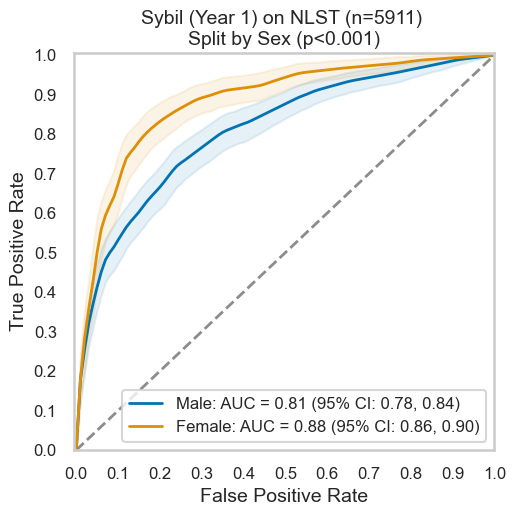

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000363,Male,0.810375,0.783843,0.836403,Female,0.881035,0.856631,0.903728,0.07066


In [33]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Sex', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCgender5911.png")

,num,pct,mal,ben,pct_mal
< 25,1899,32.126544,209,1690,11.005793
≥ 25,4012,67.873456,372,3640,9.272183


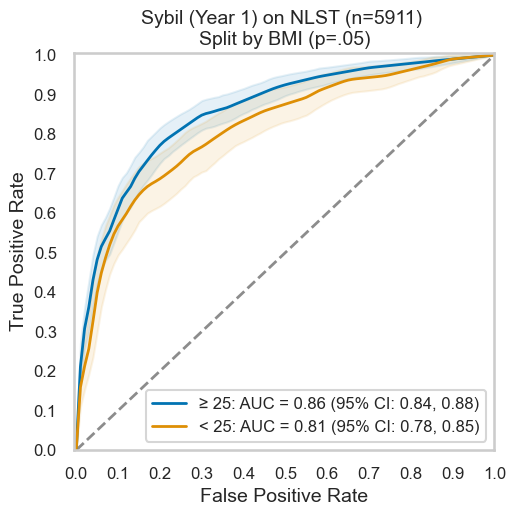

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.051435,≥ 25,0.856063,0.835375,0.87804,< 25,0.814306,0.779593,0.847962,-0.041758


In [34]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'BMI', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilBMIroc5911.png")

,num,pct,mal,ben,pct_mal
False,3755,63.52563,317,3438,8.442077
True,2156,36.47437,264,1892,12.244898


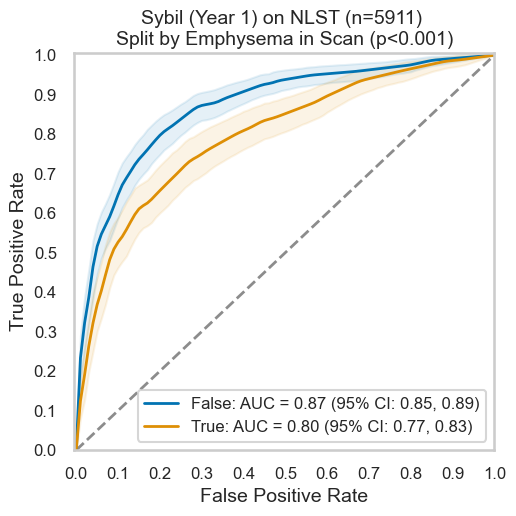

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000453,False,0.869197,0.847325,0.889735,True,0.79729,0.767805,0.828122,-0.071907


In [35]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Emphysema in Scan', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCemphysema5911.png")

## Threshold Utilities

In [36]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, DLCST_DEMOCOLS)
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = output.threshold_stats_pretty(threshold_dlcst, dlcst_policies)

In [37]:
threshold_nlst_1172 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-1172.csv', index_col=0)
threshold_nlst_1172, nlst_1172_policies = output.threshold_stats_pretty(threshold_nlst_1172, nlst_1172_policies)

In [38]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = output.threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

## Threshold Plots

### DLCST

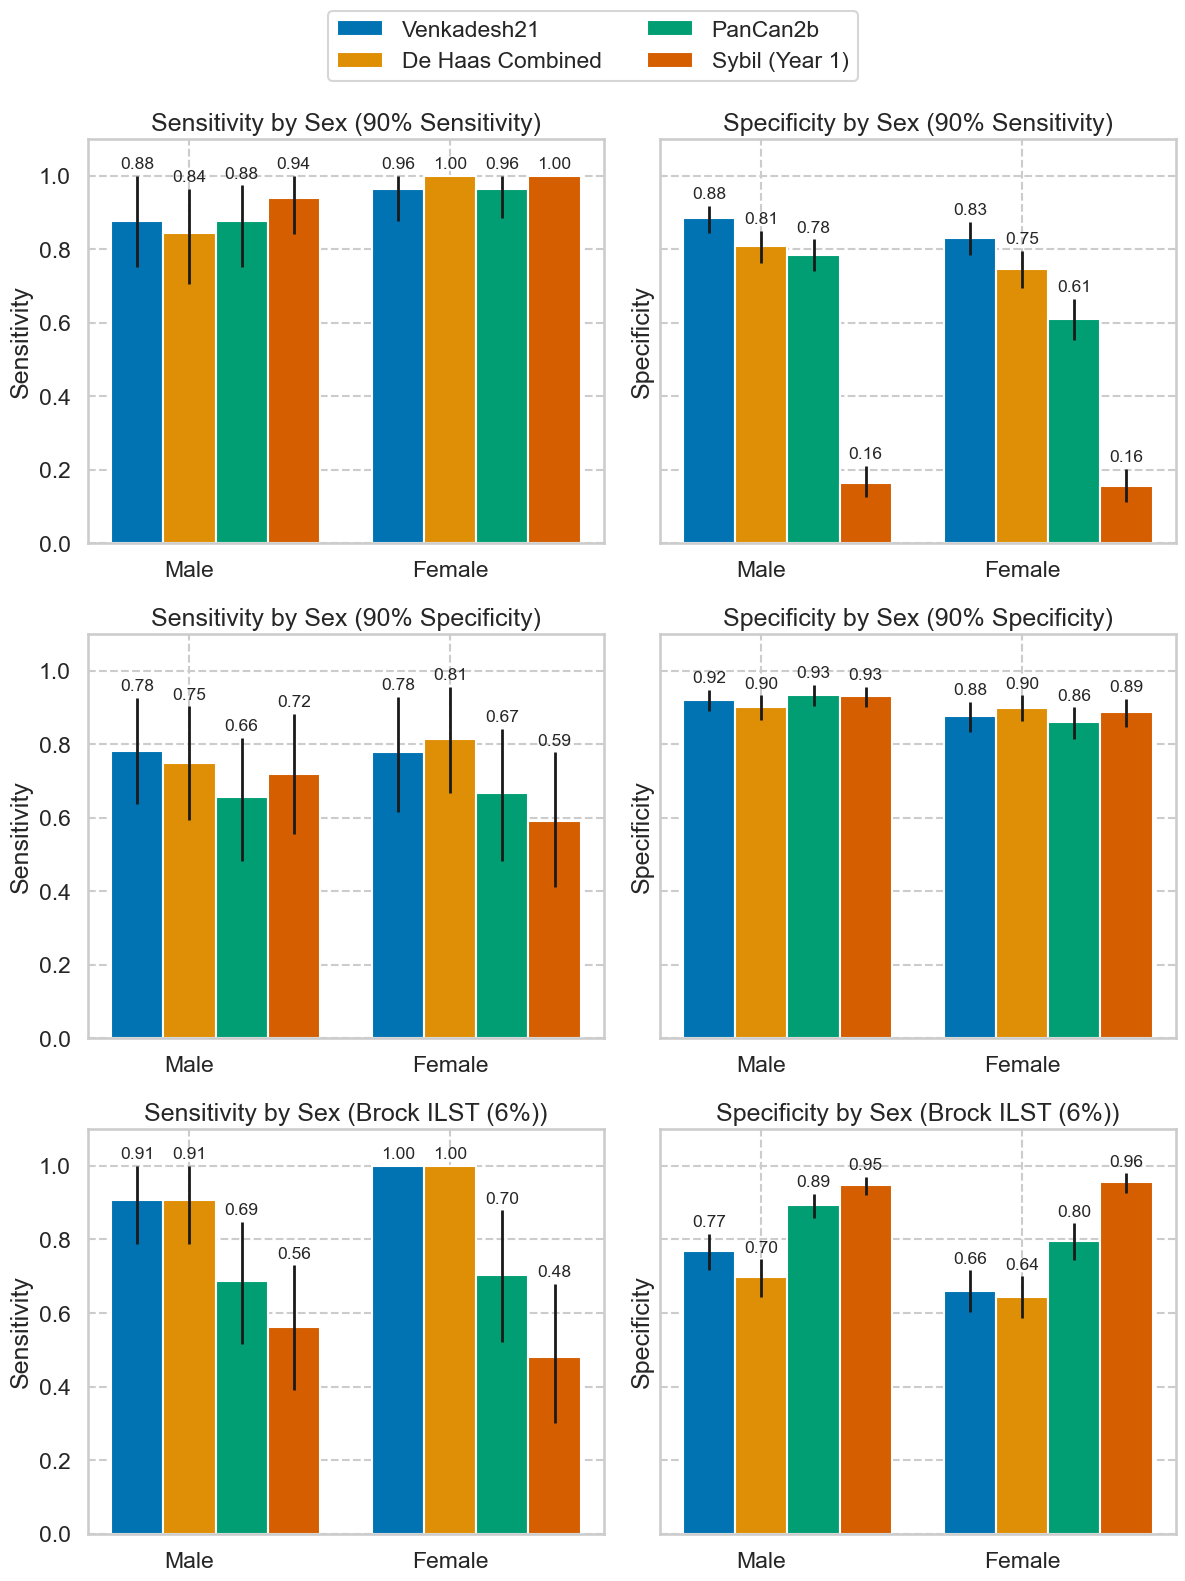

In [39]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Sex', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Sex"'),
                                             plot_metrics=['Sensitivity', 'Specificity'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

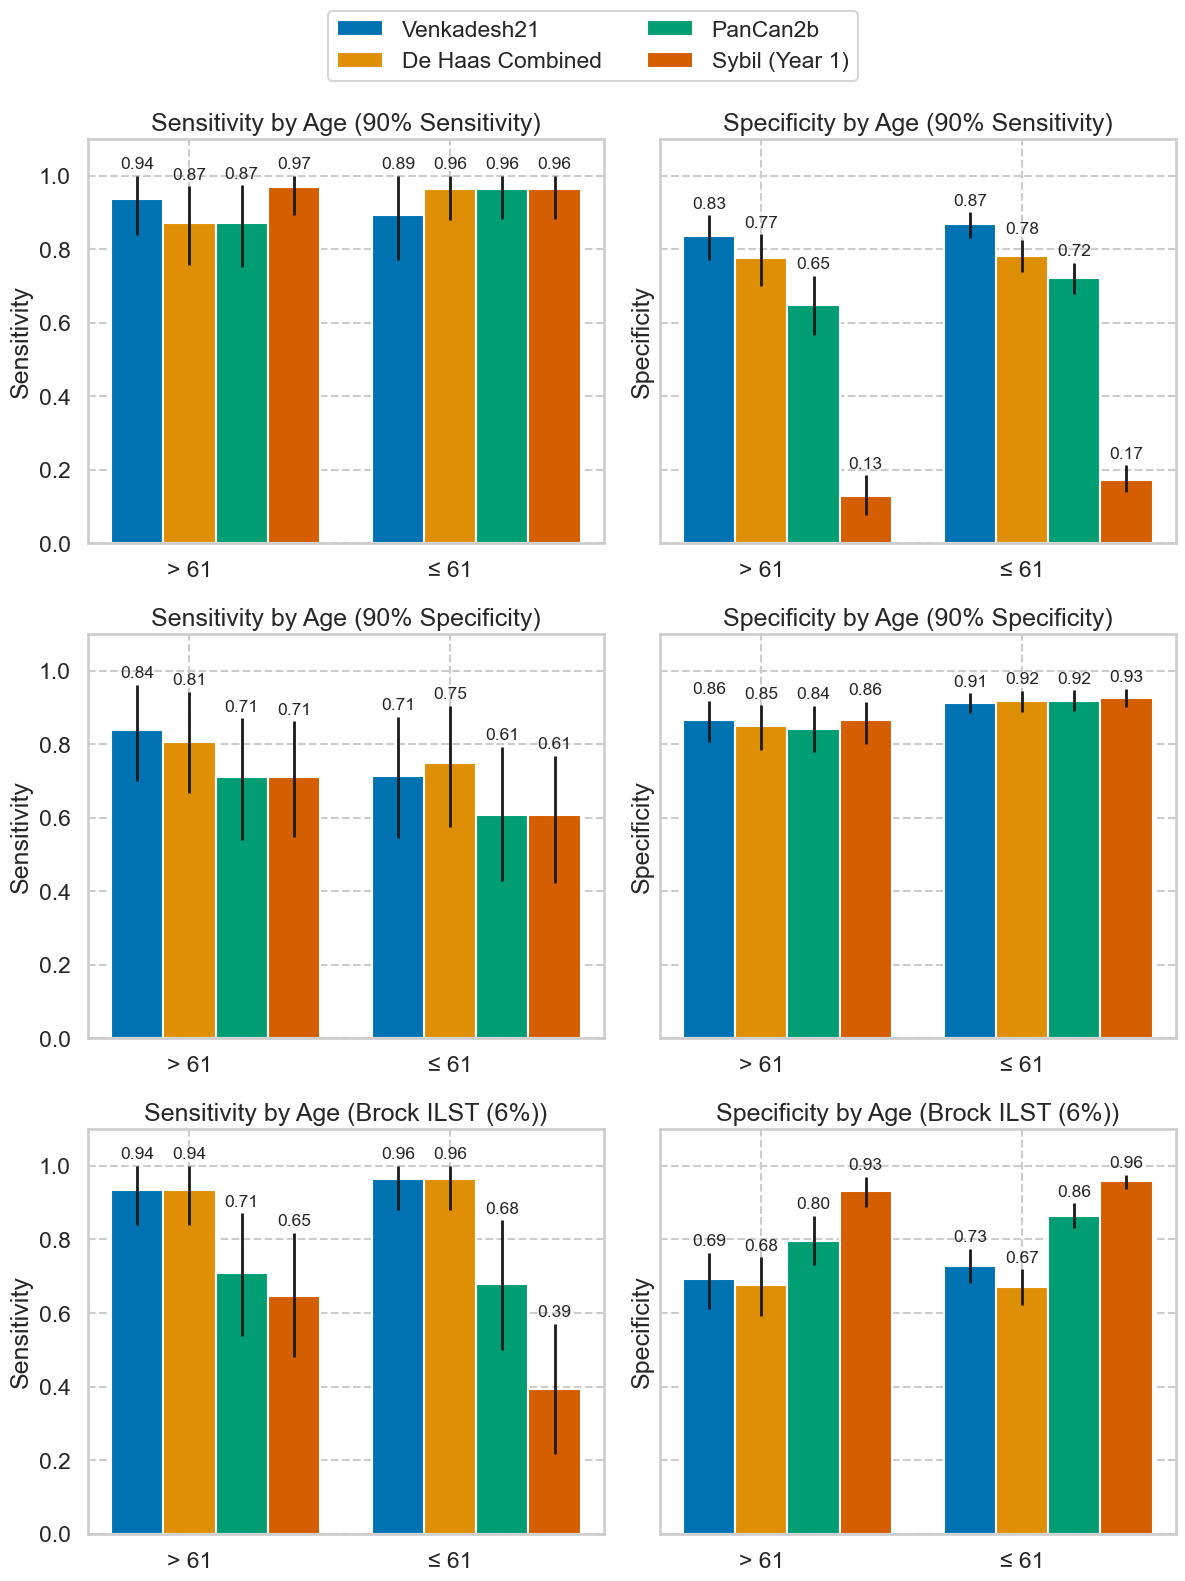

In [40]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age"'),
                                             plot_metrics=['Sensitivity', 'Specificity'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST (1172)

In [41]:
# for col in nlst_demos_to_include:
#     _ = threshold.plot_threshold_stats_subgroups(nlst_1172, col, dataset_name='NLST',
#                                                 policies=nlst_1172_policies, models=output.NLST_1172_MODELCOLS, 
#                                                 stats=threshold_nlst_1172.query(f'attribute == "{col}"'),
#                                                 plot_metrics=['Sensitivity', 'Specificity'], diff=False, show_mb_count=False,
#                                                 imgpath=f"{FIG_DIR}/threshold-NLST-1172/{col}.png"
#                                                 )  

### NLST 5911


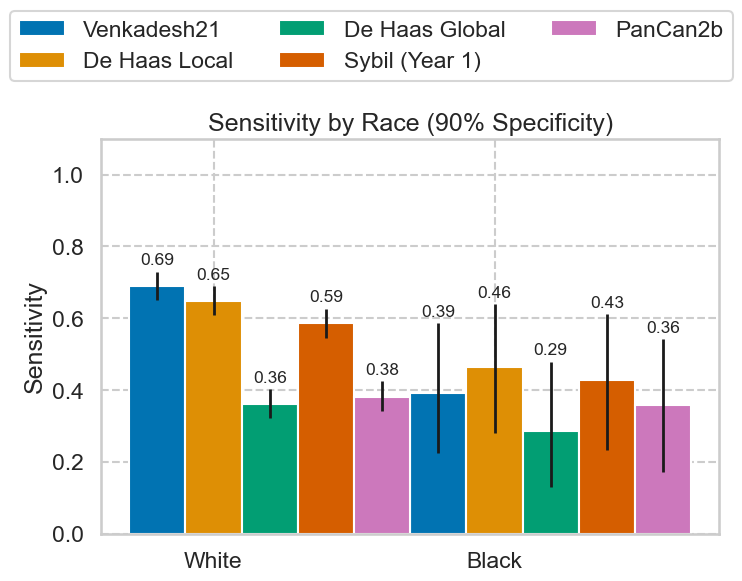

In [42]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Race", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Specificity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Race"'),
                                                plot_metrics=['Sensitivity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTPRrace5911.png"
                                                )  

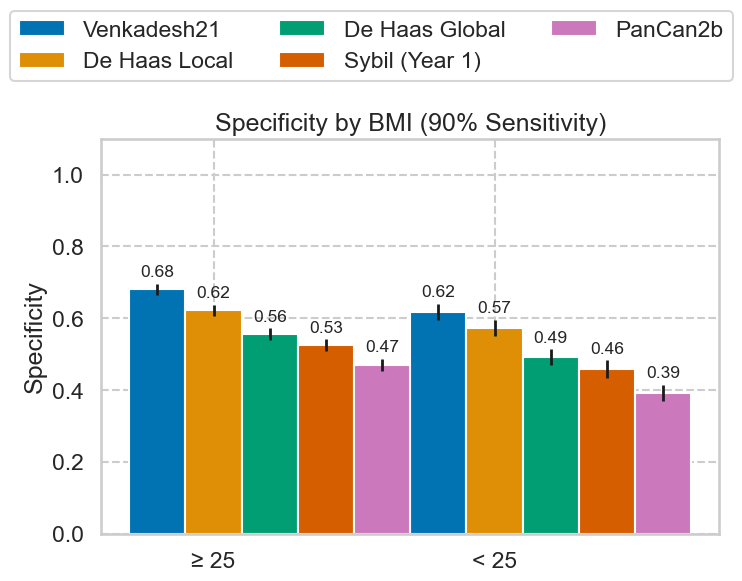

In [43]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "BMI", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "BMI"'),
                                                plot_metrics=['Specificity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRbmi5911.png"
                                                )  

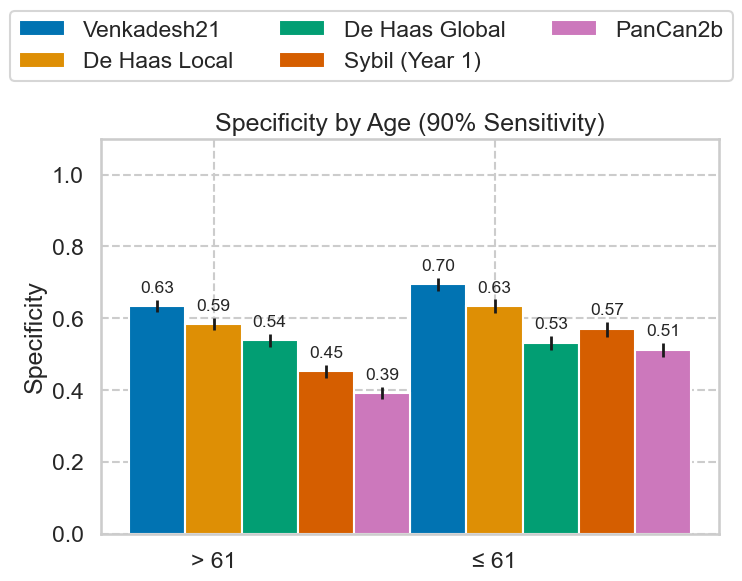

In [44]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Age", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Age"'),
                                                plot_metrics=['Specificity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRage5911.png"
                                                )  

#### all columns

In [45]:
# print(nlst_demos_to_include)
# for col in nlst_demos_to_include:
#     _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
#                                                 policies=nlst_5911_policies, models=output.NLST_5911_MODELCOLS, 
#                                                 stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
#                                                 plot_metrics=['Sensitivity', 'Specificity'], diff=False, show_mb_count=False,
#                                                 imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
#                                                 )  

## Threshold Tables

### DLCST

In [46]:
dlcst_demos_to_include = ['Age', 'Sex']
pairwise_tpr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric="Sensitivity")
threshold_tpr_dlcst = output.threshold_results_pretty(pairwise_tpr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='Sensitivity')
tpr_dlcst_demo = threshold_tpr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tpr_dlcst_demo

Venkadesh21      De Haas Combined      \
                                        Sensitivity CI        Sensitivity  CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.94 (0.84, 1.00)     0.87 (0.76, 0.97)       
                          ≤ 61    0.89 (0.77, 1.00)     0.96 (0.88, 1.00)       
                Sex       Male    0.88 (0.75, 1.00)     0.84 (0.70, 0.96)       
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)  **   
90% Specificity Age       > 61    0.84 (0.70, 0.96)     0.81 (0.67, 0.94)       
                          ≤ 61    0.71 (0.55, 0.88)     0.75 (0.58, 0.90)       
                Sex       Male    0.78 (0.64, 0.93)     0.75 (0.59, 0.90)       
                          Female  0.78 (0.62, 0.93)     0.81 (0.67, 0.96)       
Brock ILST (6%) Age       > 61    0.94 (0.84, 1.00)     0.94 (0.84, 1.00)       
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)       
                Sex       Male    0.91 (0.79, 1.00)     0.91 (0.79, 1.00)       
                          Female  1.00 (1.00, 1.00)     1.00 (1.00, 1.00)       

                                           PanCan2b        Sybil (Year 1)     
                                        Sensitivity CI        Sensitivity CI  
Policy          Attribute Group                                               
90% Sensitivity Age       > 61    0.87 (0.75, 0.97)     0.97 (0.89, 1.00)     
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)     
                Sex       Male    0.88 (0.75, 0.97)     0.94 (0.84, 1.00)     
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)     
90% Specificity Age       > 61    0.71 (0.54, 0.87)     0.71 (0.55, 0.86)     
                          ≤ 61    0.61 (0.43, 0.79)     0.61 (0.42, 0.77)     
                Sex       Male    0.66 (0.48, 0.82)     0.72 (0.56, 0.88)     
                          Female  0.67 (0.48, 0.84)     0.59 (0.41, 0.78)     
Brock ILST (6%) Age       > 61    0.71 (0.54, 0.87)     0.65 (0.48, 0.82)     
                          ≤ 61    0.68 (0.50, 0.85)     0.39 (0.22, 0.57)  *  
                Sex       Male    0.69 (0.52, 0.85)     0.56 (0.39, 0.73)     
                          Female  0.70 (0.52, 0.88)     0.48 (0.30, 0.68)

In [47]:
print(tpr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTPR.tex",
    hrules=True, label='tab:resDLCSTdemoTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (with 95\% CIs) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [139]:
tpr_dlcst_other = threshold_tpr_dlcst.xs("Other", level='Category').query('Policy in @POLICIES_TO_USE')

print(tpr_dlcst_other.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/extra-results/resDLCSTotherTPR.tex",
    hrules=True, label='tab:resDLCSTotherTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (with 95\% CIs) for models on other characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

tpr_dlcst_other

None


Venkadesh21      \
                                                  Sensitivity  CI   
Policy          Attribute            Group                          
90% Sensitivity Emphysema in Scan    True   0.91 (0.82, 0.98)       
                                     False  0.93 (0.79, 1.00)       
                Family History of LC False  0.88 (0.79, 0.97)       
                                     True   1.00 (1.00, 1.00)  **   
                Nodules Per Scan     ≤ 1    0.91 (0.81, 1.00)       
                                     > 1    0.92 (0.79, 1.00)       
90% Specificity Emphysema in Scan    True   0.80 (0.67, 0.91)       
                                     False  0.73 (0.50, 0.94)       
                Family History of LC False  0.74 (0.61, 0.88)       
                                     True   0.88 (0.69, 1.00)       
                Nodules Per Scan     ≤ 1    0.83 (0.70, 0.94)       
                                     > 1    0.71 (0.52, 0.88)       
Brock ILST (6%) Emphysema in Scan    True   0.93 (0.86, 1.00)       
                                     False  1.00 (1.00, 1.00)       
                Family History of LC False  0.93 (0.85, 1.00)       
                                     True   1.00 (1.00, 1.00)       
                Nodules Per Scan     ≤ 1    0.94 (0.85, 1.00)       
                                     > 1    0.96 (0.86, 1.00)       

                                             De Haas Combined      \
                                                  Sensitivity  CI   
Policy          Attribute            Group                          
90% Sensitivity Emphysema in Scan    True   0.91 (0.83, 0.98)       
                                     False  0.93 (0.78, 1.00)       
                Family History of LC False  0.88 (0.78, 0.97)       
                                     True   1.00 (1.00, 1.00)  **   
                Nodules Per Scan     ≤ 1    0.94 (0.85, 1.00)       
                                     > 1    0.88 (0.72, 1.00)       
90% Specificity Emphysema in Scan    True   0.80 (0.67, 0.91)       
                                     False  0.73 (0.50, 0.94)       
                Family History of LC False  0.74 (0.61, 0.86)       
                                     True   0.88 (0.69, 1.00)       
                Nodules Per Scan     ≤ 1    0.80 (0.66, 0.93)       
                                     > 1    0.75 (0.56, 0.91)       
Brock ILST (6%) Emphysema in Scan    True   0.93 (0.86, 1.00)       
                                     False  1.00 (1.00, 1.00)       
                Family History of LC False  0.93 (0.85, 1.00)       
                                     True   1.00 (1.00, 1.00)       
                Nodules Per Scan     ≤ 1    0.94 (0.85, 1.00)       
                                     > 1    0.96 (0.86, 1.00)       

                                                     PanCan2b     \
                                                  Sensitivity CI   
Policy          Attribute            Group                         
90% Sensitivity Emphysema in Scan    True   0.91 (0.81, 0.98)      
                                     False  0.93 (0.77, 1.00)      
                Family History of LC False  0.91 (0.81, 0.98)      
                                     True   0.94 (0.80, 1.00)      
                Nodules Per Scan     ≤ 1    0.94 (0.85, 1.00)      
                                     > 1    0.88 (0.73, 1.00)      
90% Specificity Emphysema in Scan    True   0.68 (0.54, 0.82)      
                                     False  0.60 (0.33, 0.83)      
                Family History of LC False  0.65 (0.50, 0.79)      
                                     True   0.69 (0.44, 0.91)      
                Nodules Per Scan     ≤ 1    0.69 (0.53, 0.84)      
                                     > 1    0.62 (0.42, 0.81)      
Brock ILST (6%) Emphysema in Scan    True   0.73 (0.59, 0.86)      
                                     False  0.60 (0.33, 0.83) 

In [48]:
pairwise_tnr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='Specificity')
threshold_tnr_dlcst = output.threshold_results_pretty(pairwise_tnr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='Specificity')
tnr_dlcst_demo = threshold_tnr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tnr_dlcst_demo

Venkadesh21       De Haas Combined     \
                                        Specificity  CI        Specificity CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.83 (0.77, 0.89)      0.77 (0.70, 0.84)      
                          ≤ 61    0.87 (0.83, 0.90)      0.78 (0.74, 0.82)      
                Sex       Male    0.88 (0.84, 0.92)      0.81 (0.76, 0.85)      
                          Female  0.83 (0.78, 0.87)   *  0.75 (0.69, 0.80)  *   
90% Specificity Age       > 61    0.86 (0.81, 0.92)      0.85 (0.79, 0.91)      
                          ≤ 61    0.91 (0.88, 0.94)      0.92 (0.89, 0.94)  *   
                Sex       Male    0.92 (0.89, 0.95)      0.90 (0.87, 0.93)      
                          Female  0.88 (0.83, 0.91)   *  0.90 (0.86, 0.93)      
Brock ILST (6%) Age       > 61    0.69 (0.61, 0.76)      0.68 (0.59, 0.75)      
                          ≤ 61    0.73 (0.68, 0.78)      0.67 (0.62, 0.72)      
                Sex       Male    0.77 (0.72, 0.82)      0.70 (0.64, 0.75)      
                          Female  0.66 (0.60, 0.72)  **  0.64 (0.59, 0.70)      

                                           PanCan2b         Sybil (Year 1)     
                                        Specificity  CI        Specificity CI  
Policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.65 (0.57, 0.73)      0.13 (0.08, 0.18)     
                          ≤ 61    0.72 (0.68, 0.76)      0.17 (0.14, 0.21)     
                Sex       Male    0.78 (0.74, 0.83)      0.16 (0.13, 0.21)     
                          Female  0.61 (0.55, 0.66)  **  0.16 (0.11, 0.20)     
90% Specificity Age       > 61    0.84 (0.78, 0.90)      0.86 (0.80, 0.92)     
                          ≤ 61    0.92 (0.89, 0.95)   *  0.93 (0.90, 0.95)  *  
                Sex       Male    0.93 (0.90, 0.96)      0.93 (0.90, 0.96)     
                          Female  0.86 (0.81, 0.90)  **  0.89 (0.85, 0.92)  *  
Brock ILST (6%) Age       > 61    0.80 (0.73, 0.86)      0.93 (0.89, 0.97)     
                          ≤ 61    0.86 (0.83, 0.90)   *  0.96 (0.94, 0.98)     
                Sex       Male    0.89 (0.86, 0.92)      0.95 (0.92, 0.97)     
                          Female  0.80 (0.74, 0.84)  **  0.96 (0.93, 0.98)

In [49]:
print(tnr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTNR.tex",
    hrules=True, label='tab:resDLCSTdemoTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (with 95\% CIs) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [138]:
tnr_dlcst_other = threshold_tnr_dlcst.xs("Other", level='Category').query('Policy in @POLICIES_TO_USE')

print(tnr_dlcst_other.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/extra-results/resDLCSTotherTNR.tex",
    hrules=True, label='tab:resDLCSTotherTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (with 95\% CIs) for models on other characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

tnr_dlcst_other

None


Venkadesh21      \
                                                  Specificity  CI   
Policy          Attribute            Group                          
90% Sensitivity Emphysema in Scan    True   0.83 (0.79, 0.87)       
                                     False  0.92 (0.87, 0.96)  **   
                Family History of LC False  0.87 (0.84, 0.89)       
                                     True   0.83 (0.74, 0.90)       
                Nodules Per Scan     ≤ 1    0.88 (0.85, 0.92)       
                                     > 1    0.83 (0.78, 0.88)   *   
90% Specificity Emphysema in Scan    True   0.87 (0.84, 0.91)       
                                     False  0.96 (0.92, 0.98)  **   
                Family History of LC False  0.90 (0.88, 0.93)       
                                     True   0.88 (0.81, 0.95)       
                Nodules Per Scan     ≤ 1    0.92 (0.88, 0.95)       
                                     > 1    0.88 (0.84, 0.92)       
Brock ILST (6%) Emphysema in Scan    True   0.68 (0.63, 0.73)       
                                     False  0.79 (0.73, 0.85)  **   
                Family History of LC False  0.72 (0.68, 0.76)       
                                     True   0.70 (0.60, 0.79)       
                Nodules Per Scan     ≤ 1    0.76 (0.71, 0.81)       
                                     > 1    0.67 (0.60, 0.72)   *   

                                             De Haas Combined     \
                                                  Specificity CI   
Policy          Attribute            Group                         
90% Sensitivity Emphysema in Scan    True   0.75 (0.71, 0.80)      
                                     False  0.83 (0.77, 0.89)  *   
                Family History of LC False  0.79 (0.75, 0.82)      
                                     True   0.73 (0.64, 0.82)      
                Nodules Per Scan     ≤ 1    0.76 (0.71, 0.81)      
                                     > 1    0.81 (0.75, 0.85)      
90% Specificity Emphysema in Scan    True   0.88 (0.84, 0.91)      
                                     False  0.94 (0.91, 0.97)  *   
                Family History of LC False  0.90 (0.87, 0.92)      
                                     True   0.92 (0.86, 0.97)      
                Nodules Per Scan     ≤ 1    0.88 (0.85, 0.92)      
                                     > 1    0.92 (0.89, 0.95)  *   
Brock ILST (6%) Emphysema in Scan    True   0.65 (0.60, 0.70)      
                                     False  0.73 (0.66, 0.79)  *   
                Family History of LC False  0.67 (0.63, 0.71)      
                                     True   0.67 (0.58, 0.77)      
                Nodules Per Scan     ≤ 1    0.67 (0.62, 0.73)      
                                     > 1    0.67 (0.61, 0.73)      

                                                     PanCan2b      \
                                                  Specificity  CI   
Policy          Attribute            Group                          
90% Sensitivity Emphysema in Scan    True   0.67 (0.62, 0.71)       
                                     False  0.78 (0.71, 0.84)  **   
                Family History of LC False  0.71 (0.67, 0.75)       
                                     True   0.67 (0.58, 0.77)       
                Nodules Per Scan     ≤ 1    0.70 (0.65, 0.75)       
                                     > 1    0.71 (0.65, 0.76)       
90% Specificity Emphysema in Scan    True   0.89 (0.85, 0.92)       
                                     False  0.93 (0.89, 0.96)   *   
                Family History of LC False  0.91 (0.88, 0.93)       
                                     True   0.87 (0.80, 0.94)       
                Nodules Per Scan     ≤ 1    0.91 (0.88, 0.94)       
                                     > 1    0.89 (0.85, 0.92)       
Brock ILST (6%) Emphysema in Scan    True   0.81 (0.77, 0.85)       
                                     False  0.92 (0.88, 0.96)  **  

### NLST 1172

In [50]:
pairwise_tpr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric="Sensitivity")
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_1172, model_order=list(output.NLST_1172_MODELCOLS.keys()), metric='Sensitivity')

In [51]:
tpr_demo_1172 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tpr_demo_1172 = tpr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tpr_demo_1172

De Haas Combined         De Haas Local     \
                                        Sensitivity CI        Sensitivity CI   
Policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.90 (0.82, 0.96)     0.90 (0.83, 0.96)      
                          ≤ 61    0.92 (0.83, 0.98)     0.92 (0.83, 0.98)      
                BMI       ≥ 25    0.89 (0.82, 0.95)     0.90 (0.84, 0.96)      
                          < 25    0.93 (0.86, 1.00)     0.91 (0.82, 0.98)      
                Height    > 68    0.90 (0.82, 0.97)     0.90 (0.83, 0.97)      
                          ≤ 68    0.91 (0.83, 0.98)     0.91 (0.84, 0.98)      
                Sex       Male    0.91 (0.84, 0.97)     0.91 (0.84, 0.97)      
                          Female  0.90 (0.80, 0.98)     0.90 (0.80, 0.98)      
                Weight    ≤ 180   0.89 (0.81, 0.96)     0.89 (0.81, 0.96)      
                          > 180   0.93 (0.86, 0.98)     0.93 (0.86, 0.98)      
90% Specificity Age       > 61    0.60 (0.49, 0.72)     0.64 (0.53, 0.74)      
                          ≤ 61    0.67 (0.53, 0.80)     0.63 (0.49, 0.76)      
                BMI       ≥ 25    0.61 (0.51, 0.71)     0.62 (0.52, 0.72)      
                          < 25    0.67 (0.53, 0.80)     0.67 (0.52, 0.80)      
                Height    > 68    0.60 (0.48, 0.71)     0.59 (0.47, 0.70)      
                          ≤ 68    0.67 (0.54, 0.79)     0.70 (0.59, 0.82)      
                Sex       Male    0.59 (0.48, 0.71)     0.61 (0.50, 0.72)      
                          Female  0.69 (0.56, 0.82)     0.69 (0.55, 0.82)      
                Weight    ≤ 180   0.68 (0.58, 0.79)     0.67 (0.56, 0.78)      
                          > 180   0.56 (0.42, 0.69)     0.59 (0.46, 0.72)      
Brock ILST (6%) Age       > 61    0.90 (0.82, 0.96)     0.85 (0.76, 0.92)      
                          ≤ 61    0.92 (0.83, 0.98)     0.90 (0.80, 0.98)      
                BMI       ≥ 25    0.89 (0.82, 0.95)     0.88 (0.81, 0.95)      
                          < 25    0.93 (0.86, 1.00)     0.84 (0.73, 0.94)      
                Height    > 68    0.90 (0.82, 0.97)     0.87 (0.79, 0.95)      
                          ≤ 68    0.91 (0.83, 0.98)     0.86 (0.77, 0.95)      
                Sex       Male    0.91 (0.84, 0.97)     0.87 (0.79, 0.94)      
                          Female  0.90 (0.80, 0.98)     0.85 (0.75, 0.94)      
                Weight    ≤ 180   0.89 (0.81, 0.96)     0.85 (0.76, 0.93)      
                          > 180   0.93 (0.86, 0.98)     0.89 (0.80, 0.97)      

                                     De Haas Global     
                                        Sensitivity CI  
Policy          Attribute Group                         
90% Sensitivity Age       > 61    0.87 (0.79, 0.94)     
                          ≤ 61    0.96 (0.89, 1.00)  *  
                BMI       ≥ 25    0.89 (0.82, 0.95)     
                          < 25    0.93 (0.85, 1.00)     
                Height    > 68    0.91 (0.84, 0.97)     
                          ≤ 68    0.89 (0.81, 0.96)     
                Sex       Male    0.92 (0.86, 0.98)     
                          Female  0.88 (0.77, 0.96)     
                Weight    ≤ 180   0.92 (0.85, 0.97)     
                          > 180   0.89 (0.80, 0.96)     
90% Specificity Age       > 61    0.29 (0.20, 0.40)     
                          ≤ 61    0.31 (0.17, 0.45)     
                BMI       ≥ 25    0.28 (0.19, 0.38)     
                          < 25    0.33 (0.20, 0.47)     
                Height    > 68    0.31 (0.21, 0.42)     
                          ≤ 68    0.28 (0.17, 0.40)     
                Sex       Male    0.34 (0.24, 0.45)     
                          Female  0.23 (0.12, 0.35)     
                Weight    ≤ 180   0.26 (0.16, 0.36)     
                          > 180   0.35 (0.23, 0.48)     
Brock ILST (6%) Age       > 61    0.87 (0.79, 0.94)     
                          

In [52]:
print(tpr_demo_1172.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTPR.tex",
    hrules=True, label='tab:resNLSTtijmenTPR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (with 95\% CIs) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [53]:
pairwise_tnr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric='Specificity')
tnr_1172 = output.threshold_results_pretty(pairwise_tnr_1172, model_order=list(output.NLST_1172_MODELCOLS.keys()), metric='Specificity')
tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')

Venkadesh21       De Haas Combined  \
                                        Specificity  CI        Specificity   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.52 (0.48, 0.56)      0.62 (0.58, 0.66)   
                          ≤ 61    0.56 (0.52, 0.61)   *  0.65 (0.61, 0.69)   
                BMI       ≥ 25    0.57 (0.53, 0.61)      0.66 (0.63, 0.70)   
                          < 25    0.46 (0.41, 0.52)  **  0.57 (0.52, 0.62)   
                Height    > 68    0.55 (0.52, 0.59)      0.66 (0.62, 0.70)   
                          ≤ 68    0.52 (0.47, 0.56)      0.61 (0.57, 0.65)   
                Sex       Male    0.54 (0.50, 0.58)      0.66 (0.63, 0.70)   
                          Female  0.53 (0.48, 0.57)      0.60 (0.55, 0.64)   
                Weight    ≤ 180   0.50 (0.46, 0.54)      0.59 (0.56, 0.64)   
                          > 180   0.57 (0.53, 0.62)   *  0.68 (0.63, 0.72)   
90% Specificity Age       > 61    0.88 (0.86, 0.91)      0.91 (0.89, 0.94)   
                          ≤ 61    0.92 (0.90, 0.94)   *  0.88 (0.85, 0.91)   
                BMI       ≥ 25    0.92 (0.90, 0.94)      0.91 (0.88, 0.93)   
                          < 25    0.86 (0.82, 0.89)  **  0.89 (0.85, 0.92)   
                Height    > 68    0.92 (0.90, 0.95)      0.90 (0.87, 0.93)   
                          ≤ 68    0.88 (0.85, 0.90)   *  0.90 (0.87, 0.93)   
                Sex       Male    0.91 (0.89, 0.93)      0.90 (0.88, 0.93)   
                          Female  0.88 (0.85, 0.91)   *  0.90 (0.87, 0.93)   
                Weight    ≤ 180   0.88 (0.86, 0.91)      0.89 (0.86, 0.91)   
                          > 180   0.92 (0.89, 0.94)   *  0.91 (0.89, 0.94)   
Brock ILST (6%) Age       > 61    0.65 (0.62, 0.69)      0.61 (0.57, 0.64)   
                          ≤ 61    0.71 (0.67, 0.75)   *  0.62 (0.57, 0.66)   
                BMI       ≥ 25    0.70 (0.67, 0.74)      0.64 (0.60, 0.68)   
                          < 25    0.62 (0.57, 0.67)   *  0.54 (0.49, 0.60)   
                Height    > 68    0.70 (0.66, 0.73)      0.63 (0.59, 0.68)   
                          ≤ 68    0.66 (0.62, 0.70)      0.59 (0.55, 0.63)   
                Sex       Male    0.68 (0.64, 0.71)      0.64 (0.60, 0.67)   
                          Female  0.68 (0.64, 0.72)      0.57 (0.52, 0.62)   
                Weight    ≤ 180   0.65 (0.61, 0.69)      0.57 (0.54, 0.62)   
                          > 180   0.70 (0.66, 0.74)   *  0.65 (0.61, 0.69)   

                                          De Haas Local        De Haas Global  \
                                  CI        Specificity CI        Specificity   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61        0.60 (0.56, 0.64)     0.54 (0.50, 0.58)   
                          ≤ 61        0.63 (0.59, 0.67)     0.49 (0.44, 0.53)   
                BMI       ≥ 25        0.64 (0.60, 0.67)     0.55 (0.51, 0.58)   
                          < 25    **  0.56 (0.51, 0.61)  *  0.45 (0.40, 0.50)   
                Height    > 68        0.62 (0.57, 0.66)     0.56 (0.52, 0.61)   
                          ≤ 68     *  0.61 (0.57, 0.64)     0.47 (0.43, 0.51)   
                Sex       Male        0.62 (0.58, 0.66)     0.55 (0.51, 0.59)   
                          Female   *  0.60 (0.55, 0.64)     0.47 (0.42, 0.52)   
                Weight    ≤ 180       0.60 (0.56, 0.64)     0.46 (0.41, 0.50)   
                          > 180    *  0.62 (0.58, 0.67)     0.58 (0.53, 0.62)   
90% Specificity Age       > 61        0.89 (0.86, 0.91)     0.91 (0.88, 0.93)   
                          ≤ 61     *  0.92 (0.90, 0.95)  *  0.89 (0.86, 0.92)   
                BMI       ≥ 25        0.92 (0.90, 0.94)     0.91 (0.89, 0.93)   
                          < 25        0.87 (0.83, 0.90)  *  0.88 (0.85, 0.92)   
                Height    > 68        0.92 (0.89, 0.94)     0.90 (0.87, 0.93)   
       

In [54]:
tnr_demo_1172 = tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tnr_demo_1172 = tnr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tnr_demo_1172

De Haas Combined          De Haas Local     \
                                        Specificity  CI        Specificity CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.62 (0.58, 0.66)      0.60 (0.56, 0.64)      
                          ≤ 61    0.65 (0.61, 0.69)      0.63 (0.59, 0.67)      
                BMI       ≥ 25    0.66 (0.63, 0.70)      0.64 (0.60, 0.67)      
                          < 25    0.57 (0.52, 0.62)  **  0.56 (0.51, 0.61)  *   
                Height    > 68    0.66 (0.62, 0.70)      0.62 (0.57, 0.66)      
                          ≤ 68    0.61 (0.57, 0.65)   *  0.61 (0.57, 0.64)      
                Sex       Male    0.66 (0.63, 0.70)      0.62 (0.58, 0.66)      
                          Female  0.60 (0.55, 0.64)   *  0.60 (0.55, 0.64)      
                Weight    ≤ 180   0.59 (0.56, 0.64)      0.60 (0.56, 0.64)      
                          > 180   0.68 (0.63, 0.72)   *  0.62 (0.58, 0.67)      
90% Specificity Age       > 61    0.91 (0.89, 0.94)      0.89 (0.86, 0.91)      
                          ≤ 61    0.88 (0.85, 0.91)   *  0.92 (0.90, 0.95)  *   
                BMI       ≥ 25    0.91 (0.88, 0.93)      0.92 (0.90, 0.94)      
                          < 25    0.89 (0.85, 0.92)      0.87 (0.83, 0.90)  *   
                Height    > 68    0.90 (0.87, 0.93)      0.92 (0.89, 0.94)      
                          ≤ 68    0.90 (0.87, 0.93)      0.89 (0.86, 0.91)  *   
                Sex       Male    0.90 (0.88, 0.93)      0.91 (0.89, 0.93)      
                          Female  0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                Weight    ≤ 180   0.89 (0.86, 0.91)      0.89 (0.86, 0.91)      
                          > 180   0.91 (0.89, 0.94)   *  0.91 (0.89, 0.94)      
Brock ILST (6%) Age       > 61    0.61 (0.57, 0.64)      0.64 (0.60, 0.67)      
                          ≤ 61    0.62 (0.57, 0.66)      0.67 (0.62, 0.71)      
                BMI       ≥ 25    0.64 (0.60, 0.68)      0.68 (0.64, 0.71)      
                          < 25    0.54 (0.49, 0.60)  **  0.59 (0.54, 0.64)  *   
                Height    > 68    0.63 (0.59, 0.68)      0.66 (0.61, 0.70)      
                          ≤ 68    0.59 (0.55, 0.63)      0.64 (0.60, 0.68)      
                Sex       Male    0.64 (0.60, 0.67)      0.66 (0.62, 0.69)      
                          Female  0.57 (0.52, 0.62)   *  0.63 (0.59, 0.68)      
                Weight    ≤ 180   0.57 (0.54, 0.62)      0.64 (0.60, 0.68)      
                          > 180   0.65 (0.61, 0.69)   *  0.66 (0.62, 0.70)      

                                     De Haas Global      
                                        Specificity  CI  
Policy          Attribute Group                          
90% Sensitivity Age       > 61    0.54 (0.50, 0.58)      
                          ≤ 61    0.49 (0.44, 0.53)   *  
                BMI       ≥ 25    0.55 (0.51, 0.58)      
                          < 25    0.45 (0.40, 0.50)  **  
                Height    > 68    0.56 (0.52, 0.61)      
                          ≤ 68    0.47 (0.43, 0.51)  **  
                Sex       Male    0.55 (0.51, 0.59)      
                          Female  0.47 (0.42, 0.52)   *  
                Weight    ≤ 180   0.46 (0.41, 0.50)      
                          > 180   0.58 (0.53, 0.62)  **  
90% Specificity Age       > 61    0.91 (0.88, 0.93)      
                          ≤ 61    0.89 (0.86, 0.92)      
                BMI       ≥ 25    0.91 (0.89, 0.93)      
                          < 25    0.88 (0.85, 0.92)      
                Height    > 68    0.90 (0.87, 0.93)      
                          ≤ 68    0.90 (0.88, 0.92)      
                Sex       Male    0.90 (0.88, 0.92)      
                          Female  0.90 (0.87, 0.93)      
                Weight    ≤ 180   0.89 (0.87, 0.92)      
                          > 180   0.91 (0.88, 0.93)      
Brock ILST (6%) Age       >

In [55]:
print(tnr_demo_1172.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTNR.tex",
    hrules=True, label='tab:resNLSTtijmenTNR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (with 95\% CIs) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 5911

In [56]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="Sensitivity")
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='Sensitivity')
tpr_demo_5911 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tpr_demo_5911

Venkadesh21          De Haas Local     \
                                        Sensitivity  CI        Sensitivity CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.90 (0.86, 0.93)      0.90 (0.87, 0.93)      
                          ≤ 61    0.91 (0.87, 0.94)      0.91 (0.88, 0.95)      
                BMI       ≥ 25    0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                          < 25    0.90 (0.86, 0.94)      0.93 (0.89, 0.96)      
                Height    ≤ 68    0.90 (0.87, 0.94)      0.92 (0.89, 0.95)      
                          > 68    0.90 (0.85, 0.93)      0.89 (0.85, 0.92)      
                Race      White   0.90 (0.88, 0.93)      0.90 (0.87, 0.93)      
                          Black   0.82 (0.67, 0.96)      0.89 (0.77, 1.00)      
                Sex       Male    0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                          Female  0.90 (0.86, 0.93)      0.92 (0.89, 0.95)      
                Weight    ≤ 180   0.91 (0.87, 0.94)      0.91 (0.88, 0.94)      
                          > 180   0.89 (0.85, 0.93)      0.89 (0.86, 0.93)      
90% Specificity Age       > 61    0.70 (0.66, 0.75)      0.67 (0.62, 0.71)      
                          ≤ 61    0.65 (0.58, 0.71)      0.62 (0.56, 0.68)      
                BMI       ≥ 25    0.68 (0.63, 0.72)      0.65 (0.60, 0.70)      
                          < 25    0.69 (0.62, 0.75)      0.65 (0.58, 0.71)      
                Height    ≤ 68    0.70 (0.65, 0.75)      0.67 (0.61, 0.72)      
                          > 68    0.66 (0.61, 0.72)      0.63 (0.57, 0.68)      
                Race      White   0.69 (0.65, 0.73)      0.65 (0.61, 0.69)      
                          Black   0.39 (0.23, 0.59)  **  0.46 (0.28, 0.64)  *   
                Sex       Male    0.66 (0.61, 0.71)      0.64 (0.59, 0.68)      
                          Female  0.71 (0.65, 0.77)      0.67 (0.61, 0.73)      
                Weight    ≤ 180   0.69 (0.64, 0.73)      0.66 (0.61, 0.71)      
                          > 180   0.68 (0.62, 0.73)      0.63 (0.57, 0.69)      
Brock ILST (6%) Age       > 61    0.88 (0.84, 0.91)      0.85 (0.81, 0.89)      
                          ≤ 61    0.89 (0.85, 0.93)      0.89 (0.85, 0.93)      
                BMI       ≥ 25    0.89 (0.86, 0.92)      0.85 (0.81, 0.88)      
                          < 25    0.88 (0.83, 0.92)      0.89 (0.84, 0.93)      
                Height    ≤ 68    0.89 (0.85, 0.92)      0.87 (0.83, 0.91)      
                          > 68    0.88 (0.84, 0.91)      0.86 (0.82, 0.90)      
                Race      White   0.89 (0.86, 0.91)      0.86 (0.83, 0.89)      
                          Black   0.75 (0.59, 0.91)      0.79 (0.64, 0.92)      
                Sex       Male    0.88 (0.85, 0.91)      0.85 (0.81, 0.89)      
                          Female  0.89 (0.85, 0.92)      0.89 (0.84, 0.92)      
                Weight    ≤ 180   0.88 (0.84, 0.91)      0.87 (0.83, 0.91)      
                          > 180   0.89 (0.85, 0.93)      0.85 (0.81, 0.90)      

                                     De Haas Global        Sybil (Year 1)      \
                                        Sensitivity CI        Sensitivity  CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.89 (0.86, 0.92)     0.91 (0.88, 0.94)       
                          ≤ 61    0.91 (0.88, 0.95)     0.90 (0.86, 0.94)       
                BMI       ≥ 25    0.89 (0.86, 0.92)     0.92 (0.89, 0.95)       
                          < 25    0.92 (0.88, 0.96)     0.89 (0.84, 0.93)       
                Height    ≤ 68    0.90 (0.87, 0.93)     0.92 (0.89, 0.95)       
                          > 68    0.90 (0.86, 0.93)     0.89 (0.85, 0.92)       
                Race      White   0.90 (0.87, 0.92)     0.91 (0.89, 0.93)       
                          Black   0.96 (0.88, 1.00)     0.86 (0.71, 0.

In [57]:
print(tpr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTPR.tex",
    hrules=True, label='tab:resNLSTfullTPR', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (with 95\% CIs) for models on demographic characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [169]:
for category in data.rename_types.values():
    if category in ['Scanner', 'Demographics', 'Lung Cancer', 'Previous Cancer Diagnosis']:
        continue
    
    df_cat = threshold_tpr.xs(category, level='Category').query('Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
    print(df_cat.style.format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0).to_latex(
        buf=f"{TAB_DIR}/extra-results/nlst-tpr-{category}.tex",
    hrules=True, label=f'tab:nlst5911TPR-{category}', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='htbp!',
        multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
        caption=f'Sensitivity (with 95\% CIs) for models on {category} characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))
    
    print(category)
    display(df_cat)

None
Smoking


Venkadesh21     \
                                                    Sensitivity CI   
Policy          Attribute              Group                         
90% Sensitivity Age at Smoking Onset   ≤ 16   0.91 (0.88, 0.94)      
                                       > 16   0.88 (0.84, 0.92)      
                Cigarettes per Day     > 25   0.92 (0.89, 0.95)      
                                       ≤ 25   0.88 (0.84, 0.92)  *   
                Current Smoker         True   0.89 (0.85, 0.92)      
                                       False  0.91 (0.88, 0.95)      
                Lived w/ Smoker        True   0.90 (0.88, 0.93)      
                                       False  0.88 (0.79, 0.95)      
                Pack-Years             > 55   0.91 (0.88, 0.95)      
                                       ≤ 55   0.89 (0.85, 0.92)      
                Smoked Cigars          False  0.91 (0.88, 0.93)      
                                       True   0.87 (0.80, 0.93)      
                Smoked Pipe            False  0.89 (0.86, 0.92)      
                                       True   0.94 (0.89, 0.97)  *   
                Total Years of Smoking > 40   0.91 (0.88, 0.94)      
                                       ≤ 40   0.88 (0.84, 0.93)      
                Worked w/ Smoker       True   0.91 (0.88, 0.93)      
                                       False  0.86 (0.77, 0.94)      
90% Specificity Age at Smoking Onset   ≤ 16   0.67 (0.62, 0.71)      
                                       > 16   0.70 (0.64, 0.76)      
                Cigarettes per Day     > 25   0.72 (0.67, 0.78)      
                                       ≤ 25   0.64 (0.58, 0.69)  *   
                Current Smoker         True   0.70 (0.65, 0.74)      
                                       False  0.66 (0.61, 0.72)      
                Lived w/ Smoker        True   0.69 (0.65, 0.73)      
                                       False  0.61 (0.49, 0.72)      
                Pack-Years             > 55   0.71 (0.66, 0.76)      
                                       ≤ 55   0.65 (0.60, 0.71)  *   
                Smoked Cigars          False  0.70 (0.66, 0.75)      
                                       True   0.59 (0.50, 0.68)  *   
                Smoked Pipe            False  0.69 (0.64, 0.74)      
                                       True   0.65 (0.57, 0.73)      
                Total Years of Smoking > 40   0.71 (0.66, 0.75)      
                                       ≤ 40   0.63 (0.57, 0.70)  *   
                Worked w/ Smoker       True   0.69 (0.65, 0.74)      
                                       False  0.60 (0.48, 0.72)      
Brock ILST (6%) Age at Smoking Onset   ≤ 16   0.90 (0.86, 0.93)      
                                       > 16   0.86 (0.82, 0.90)      
                Cigarettes per Day     > 25   0.91 (0.87, 0.94)      
                                       ≤ 25   0.86 (0.81, 0.90)  *   
                Current Smoker         True   0.87 (0.83, 0.91)      
                                       False  0.90 (0.86, 0.93)      
                Lived w/ Smoker        True   0.89 (0.86, 0.91)      
                                       False  0.86 (0.78, 0.94)      
                Pack-Years             > 55   0.90 (0.87, 0.94)      
                                       ≤ 55   0.86 (0.82, 0.90)  *   
                Smoked Cigars          False  0.89 (0.86, 0.92)      
                                       True   0.84 (0.77, 0.91)      
                Smoked Pipe            False  0.87 (0.84, 0.90)      
                                       True   0.91 (0.86, 0.95)      
                Total Years of Smoking > 40   0.89 (0.86, 0.92)      
                                       ≤ 40   0.86 (0.82, 0.91)      
                Worked w/ Smoker       True   0.89 (0.86, 0.91)      
                                       False  0.85 (0.75, 0.93)      

                                                  De Haas Loc

None
Nodule


Venkadesh21      \
                                                  Sensitivity  CI   
Policy          Attribute            Group                          
90% Sensitivity Nodule in Upper Lung True   0.88 (0.84, 0.91)       
                                     False  0.94 (0.90, 0.97)   *   
                Non-Solid Nodule     False  0.91 (0.89, 0.93)       
                                     True   0.79 (0.68, 0.89)   *   
                Part-Solid Nodule    False  0.90 (0.87, 0.92)       
                                     True   0.92 (0.87, 0.97)       
                Solid Nodule         True   0.91 (0.88, 0.94)       
                                     False  0.87 (0.81, 0.92)       
90% Specificity Nodule in Upper Lung True   0.67 (0.62, 0.71)       
                                     False  0.70 (0.64, 0.76)       
                Non-Solid Nodule     False  0.71 (0.67, 0.75)       
                                     True   0.36 (0.23, 0.49)  **   
                Part-Solid Nodule    False  0.66 (0.62, 0.70)       
                                     True   0.79 (0.71, 0.86)  **   
                Solid Nodule         True   0.70 (0.66, 0.74)       
                                     False  0.62 (0.54, 0.70)   *   
Brock ILST (6%) Nodule in Upper Lung True   0.85 (0.82, 0.89)       
                                     False  0.93 (0.90, 0.96)  **   
                Non-Solid Nodule     False  0.90 (0.87, 0.92)       
                                     True   0.74 (0.60, 0.85)  **   
                Part-Solid Nodule    False  0.87 (0.84, 0.90)       
                                     True   0.92 (0.87, 0.97)       
                Solid Nodule         True   0.89 (0.86, 0.92)       
                                     False  0.85 (0.78, 0.90)       

                                                De Haas Local      \
                                                  Sensitivity  CI   
Policy          Attribute            Group                          
90% Sensitivity Nodule in Upper Lung True   0.90 (0.86, 0.93)       
                                     False  0.91 (0.88, 0.95)       
                Non-Solid Nodule     False  0.91 (0.89, 0.94)       
                                     True   0.81 (0.70, 0.91)   *   
                Part-Solid Nodule    False  0.90 (0.87, 0.92)       
                                     True   0.93 (0.88, 0.97)       
                Solid Nodule         True   0.91 (0.88, 0.94)       
                                     False  0.88 (0.83, 0.93)       
90% Specificity Nodule in Upper Lung True   0.63 (0.58, 0.68)       
                                     False  0.68 (0.62, 0.74)       
                Non-Solid Nodule     False  0.68 (0.64, 0.72)       
                                     True   0.32 (0.21, 0.45)  **   
                Part-Solid Nodule    False  0.64 (0.59, 0.68)       
                                     True   0.70 (0.60, 0.78)       
                Solid Nodule         True   0.68 (0.64, 0.73)       
                                     False  0.55 (0.46, 0.63)  **   
Brock ILST (6%) Nodule in Upper Lung True   0.86 (0.82, 0.89)       
                                     False  0.88 (0.83, 0.91)       
                Non-Solid Nodule     False  0.88 (0.85, 0.90)       
                                     True   0.75 (0.64, 0.87)   *   
                Part-Solid Nodule    False  0.85 (0.82, 0.88)       
                                     True   0.92 (0.86, 0.97)   *   
                Solid Nodule         True   0.87 (0.83, 0.90)       
                                     False  0.85 (0.79, 0.91)       

                                               De Haas Global      \
                                                  Sensitivity  CI   
Policy          Attribute            Group                          
90% Sensitivity Nodule in Upper Lung True   0.93 (0.90, 0.96)       
                                     False  0.

None
Other


Venkadesh21      \
                                                       Sensitivity  CI   
Policy          Attribute                 Group                          
90% Sensitivity Diameter (mm)             > 7    0.93 (0.91, 0.95)       
                                          ≤ 7    0.69 (0.58, 0.79)  **   
                Emphysema in Scan         False  0.90 (0.86, 0.93)       
                                          True   0.90 (0.87, 0.94)       
                Family History of LC      False  0.91 (0.88, 0.94)       
                                          True   0.88 (0.82, 0.92)       
                Nodules Per Scan          > 1    0.92 (0.90, 0.94)       
                                          ≤ 1    0.85 (0.78, 0.90)   *   
                Previous Cancer Diagnosis False  0.90 (0.87, 0.92)       
                                          True   0.90 (0.77, 1.00)       
                Slices In Scan            ≤ 200  0.92 (0.89, 0.94)       
                                          > 200  0.83 (0.77, 0.90)   *   
                Work w/o Mask             False  0.90 (0.87, 0.93)       
                                          True   0.90 (0.85, 0.94)       
90% Specificity Diameter (mm)             > 7    0.75 (0.71, 0.79)       
                                          ≤ 7    0.26 (0.17, 0.36)  **   
                Emphysema in Scan         False  0.68 (0.63, 0.73)       
                                          True   0.69 (0.63, 0.74)       
                Family History of LC      False  0.69 (0.65, 0.74)       
                                          True   0.66 (0.59, 0.73)       
                Nodules Per Scan          > 1    0.72 (0.67, 0.76)       
                                          ≤ 1    0.59 (0.51, 0.66)  **   
                Previous Cancer Diagnosis False  0.68 (0.65, 0.72)       
                                          True   0.62 (0.44, 0.81)       
                Slices In Scan            ≤ 200  0.69 (0.64, 0.73)       
                                          > 200  0.66 (0.58, 0.75)       
                Work w/o Mask             False  0.70 (0.65, 0.74)       
                                          True   0.63 (0.55, 0.71)       
Brock ILST (6%) Diameter (mm)             > 7    0.92 (0.90, 0.95)       
                                          ≤ 7    0.62 (0.51, 0.74)  **   
                Emphysema in Scan         False  0.88 (0.84, 0.92)       
                                          True   0.89 (0.85, 0.92)       
                Family History of LC      False  0.90 (0.87, 0.92)       
                                          True   0.86 (0.80, 0.91)       
                Nodules Per Scan          > 1    0.90 (0.88, 0.93)       
                                          ≤ 1    0.83 (0.76, 0.88)   *   
                Previous Cancer Diagnosis False  0.88 (0.85, 0.91)       
                                          True   0.90 (0.77, 1.00)       
                Slices In Scan            ≤ 200  0.90 (0.87, 0.92)       
                                          > 200  0.83 (0.77, 0.90)       
                Work w/o Mask             False  0.88 (0.85, 0.91)       
                                          True   0.88 (0.82, 0.93)       

                                                     De Haas Local      \
                                                       Sensitivity  CI   
Policy          Attribute                 Group                          
90% Sensitivity Diameter (mm)             > 7    0.93 (0.91, 0.95)       
                                          ≤ 7    0.72 (0.62, 0.83)  **   
                Emphysema in Scan         False  0.89 (0.86, 0.93)       
                                          True   0.92 (0.88, 0.95)       
                Family History of LC      False  0.91 (0.88, 0.94)       
                                          True   0.88 (0.83, 0.93)       
                Nodules Per Scan          > 1    0.92 (0.8

None
Work History


Venkadesh21  \
                                                               Sensitivity   
Policy          Attribute                         Group                      
90% Sensitivity Work - Asbestos                   False  0.90 (0.87, 0.92)   
                                                  True   0.92 (0.83, 1.00)   
                Work - Baking                     False  0.90 (0.88, 0.93)   
                                                  True   0.80 (0.60, 1.00)   
                Work - Chemicals or Plastics Mfg. False  0.90 (0.87, 0.92)   
                                                  True   0.91 (0.80, 1.00)   
                Work - Farming                    False  0.90 (0.87, 0.92)   
                                                  True   0.94 (0.86, 1.00)   
                Work - Firefighting               True   0.94 (0.80, 1.00)   
                                                  False  0.90 (0.87, 0.92)   
                Work - Foundry or Steel Milling   False  0.91 (0.88, 0.93)   
                                                  True   0.80 (0.67, 0.93)   
                Work - Painting                   False  0.90 (0.87, 0.92)   
                                                  True   0.97 (0.91, 1.00)   
                Work - Sandblasting               False  0.91 (0.88, 0.93)   
                                                  True   0.77 (0.58, 0.95)   
                Work - Welding                    False  0.89 (0.87, 0.92)   
                                                  True   0.97 (0.91, 1.00)   
90% Specificity Work - Asbestos                   False  0.69 (0.65, 0.73)   
                                                  True   0.56 (0.41, 0.72)   
                Work - Baking                     False  0.69 (0.65, 0.72)   
                                                  True   0.50 (0.29, 0.74)   
                Work - Chemicals or Plastics Mfg. False  0.68 (0.65, 0.72)   
                                                  True   0.67 (0.50, 0.83)   
                Work - Farming                    False  0.68 (0.64, 0.72)   
                                                  True   0.70 (0.57, 0.82)   
                Work - Firefighting               False  0.69 (0.65, 0.72)   
                                                  True   0.50 (0.25, 0.75)   
                Work - Foundry or Steel Milling   False  0.69 (0.65, 0.73)   
                                                  True   0.54 (0.37, 0.71)   
                Work - Painting                   False  0.68 (0.64, 0.72)   
                                                  True   0.75 (0.60, 0.89)   
                Work - Sandblasting               False  0.69 (0.66, 0.73)   
                                                  True   0.41 (0.20, 0.64)   
                Work - Welding                    False  0.68 (0.64, 0.72)   
                                                  True   0.70 (0.57, 0.83)   
Brock ILST (6%) Work - Asbestos                   False  0.88 (0.85, 0.91)   
                                                  True   0.87 (0.75, 0.97)   
                Work - Baking                     False  0.89 (0.86, 0.91)   
                                                  True   0.80 (0.60, 1.00)   
                Work - Chemicals or Plastics Mfg. False  0.88 (0.85, 0.91)   
                                                  True   0.91 (0.80, 1.00)   
                Work - Farming                    False  0.88 (0.85, 0.90)   
                                                  True   0.94 (0.86, 1.00)   
                Work - Firefighting               False  0.88 (0.85, 0.91)   
                                                  True   0.88 (0.69, 1.00)   
                Work - Foundry or Steel Milling   False  0.89 (0.86, 0.92)   
                                                  True   0.77 (0.63, 0.91)   
                Work - Painting                   False  0.88 (0.85, 0.90)   
       

None
Disease Diagnosis


Venkadesh21     \
                                                      Sensitivity CI   
Policy          Attribute                Group                         
90% Sensitivity Adult Asthma Diag.       False  0.90 (0.88, 0.92)      
                                         True   0.90 (0.80, 0.98)      
                COPD Diag.               False  0.90 (0.87, 0.92)      
                                         True   0.92 (0.85, 0.98)      
                Chronic Bronchitis Diag. False  0.90 (0.87, 0.92)      
                                         True   0.91 (0.83, 0.98)      
                Diabetes Diag.           False  0.90 (0.88, 0.93)      
                                         True   0.88 (0.78, 0.95)      
                Emphysema Diag.          False  0.90 (0.87, 0.92)      
                                         True   0.90 (0.83, 0.96)      
                Heart Disease or Attack  False  0.90 (0.88, 0.93)      
                                         True   0.89 (0.81, 0.95)      
                Hypertension Diag.       False  0.92 (0.89, 0.95)      
                                         True   0.87 (0.83, 0.91)  *   
                Pneumonia Diag.          False  0.91 (0.89, 0.94)      
                                         True   0.88 (0.82, 0.93)      
                Stroke                   False  0.90 (0.88, 0.93)      
                                         True   0.83 (0.67, 0.96)      
90% Specificity Adult Asthma Diag.       False  0.69 (0.65, 0.73)      
                                         True   0.59 (0.44, 0.76)      
                COPD Diag.               False  0.68 (0.64, 0.72)      
                                         True   0.71 (0.60, 0.82)      
                Chronic Bronchitis Diag. False  0.68 (0.64, 0.72)      
                                         True   0.68 (0.55, 0.80)      
                Diabetes Diag.           False  0.68 (0.64, 0.72)      
                                         True   0.72 (0.60, 0.83)      
                Emphysema Diag.          False  0.68 (0.64, 0.72)      
                                         True   0.68 (0.59, 0.78)      
                Heart Disease or Attack  False  0.67 (0.64, 0.72)      
                                         True   0.74 (0.64, 0.83)      
                Hypertension Diag.       False  0.72 (0.67, 0.76)      
                                         True   0.63 (0.56, 0.69)  *   
                Pneumonia Diag.          False  0.70 (0.66, 0.74)      
                                         True   0.64 (0.56, 0.72)      
                Stroke                   False  0.68 (0.64, 0.72)      
                                         True   0.75 (0.56, 0.91)      
Brock ILST (6%) Adult Asthma Diag.       False  0.88 (0.85, 0.91)      
                                         True   0.90 (0.80, 0.98)      
                COPD Diag.               False  0.88 (0.85, 0.91)      
                                         True   0.92 (0.85, 0.98)      
                Chronic Bronchitis Diag. False  0.88 (0.85, 0.91)      
                                         True   0.89 (0.81, 0.97)      
                Diabetes Diag.           False  0.89 (0.86, 0.91)      
                                         True   0.86 (0.76, 0.94)      
                Emphysema Diag.          False  0.88 (0.85, 0.91)      
                                         True   0.88 (0.81, 0.94)      
                Heart Disease or Attack  False  0.88 (0.85, 0.91)      
                                         True   0.89 (0.81, 0.95)      
                Hypertension Diag.       False  0.90 (0.87, 0.93)      
                                         True   0.86 (0.81, 0.90)  *   
                Pneumonia Diag.          False  0.89 (0.86, 0.92)      
                                         True   0.88 (0.81, 0.93)      
                Stroke                   False  0.88 (0.86, 0.91)      
                      

In [58]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="Specificity")
threshold_tnr = output.threshold_results_pretty(pairwise_tnr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='Specificity')
tnr_demo_5911 = threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tnr_demo_5911

Venkadesh21          De Haas Local  \
                                        Specificity  CI        Specificity   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.63 (0.62, 0.65)      0.59 (0.57, 0.60)   
                          ≤ 61    0.70 (0.68, 0.71)  **  0.63 (0.61, 0.65)   
                BMI       ≥ 25    0.68 (0.67, 0.70)      0.62 (0.61, 0.64)   
                          < 25    0.62 (0.59, 0.64)  **  0.57 (0.55, 0.60)   
                Height    ≤ 68    0.68 (0.66, 0.69)      0.61 (0.60, 0.63)   
                          > 68    0.64 (0.63, 0.66)   *  0.60 (0.58, 0.62)   
                Race      White   0.66 (0.65, 0.67)      0.61 (0.59, 0.62)   
                          Black   0.73 (0.66, 0.79)   *  0.59 (0.52, 0.66)   
                Sex       Male    0.65 (0.63, 0.66)      0.61 (0.59, 0.63)   
                          Female  0.68 (0.66, 0.70)   *  0.61 (0.59, 0.63)   
                Weight    ≤ 180   0.65 (0.63, 0.67)      0.59 (0.57, 0.61)   
                          > 180   0.67 (0.66, 0.69)   *  0.63 (0.61, 0.65)   
90% Specificity Age       > 61    0.88 (0.87, 0.89)      0.89 (0.88, 0.90)   
                          ≤ 61    0.92 (0.91, 0.93)  **  0.92 (0.90, 0.93)   
                BMI       ≥ 25    0.91 (0.90, 0.92)      0.91 (0.90, 0.92)   
                          < 25    0.87 (0.86, 0.89)  **  0.88 (0.86, 0.89)   
                Height    ≤ 68    0.90 (0.89, 0.91)      0.91 (0.89, 0.92)   
                          > 68    0.90 (0.89, 0.91)      0.89 (0.88, 0.91)   
                Race      White   0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Black   0.93 (0.89, 0.97)      0.91 (0.87, 0.96)   
                Sex       Male    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Female  0.90 (0.88, 0.91)      0.90 (0.89, 0.91)   
                Weight    ≤ 180   0.89 (0.88, 0.90)      0.89 (0.88, 0.91)   
                          > 180   0.91 (0.90, 0.92)  **  0.91 (0.89, 0.92)   
Brock ILST (6%) Age       > 61    0.67 (0.65, 0.69)      0.65 (0.63, 0.67)   
                          ≤ 61    0.73 (0.71, 0.75)  **  0.70 (0.68, 0.71)   
                BMI       ≥ 25    0.72 (0.70, 0.73)      0.69 (0.67, 0.70)   
                          < 25    0.66 (0.63, 0.68)  **  0.64 (0.61, 0.66)   
                Height    ≤ 68    0.71 (0.70, 0.73)      0.68 (0.67, 0.70)   
                          > 68    0.68 (0.66, 0.70)  **  0.65 (0.64, 0.67)   
                Race      White   0.70 (0.68, 0.71)      0.67 (0.66, 0.68)   
                          Black   0.76 (0.69, 0.82)      0.68 (0.61, 0.75)   
                Sex       Male    0.68 (0.66, 0.70)      0.66 (0.65, 0.68)   
                          Female  0.72 (0.70, 0.74)  **  0.68 (0.66, 0.70)   
                Weight    ≤ 180   0.69 (0.67, 0.70)      0.65 (0.64, 0.67)   
                          > 180   0.71 (0.69, 0.73)   *  0.69 (0.67, 0.71)   

                                         De Haas Global      \
                                  CI        Specificity  CI   
Policy          Attribute Group                               
90% Sensitivity Age       > 61        0.54 (0.52, 0.56)       
                          ≤ 61    **  0.53 (0.51, 0.55)       
                BMI       ≥ 25        0.56 (0.54, 0.57)       
                          < 25    **  0.49 (0.47, 0.51)  **   
                Height    ≤ 68        0.52 (0.50, 0.54)       
                          > 68        0.55 (0.53, 0.57)   *   
                Race      White       0.54 (0.52, 0.55)       
                          Black       0.49 (0.41, 0.56)       
                Sex       Male        0.55 (0.53, 0.57)       
                          Female      0.51 (0.49, 0.53)   *   
                Weight    ≤ 180       0.50 (0.48, 0.52)       
                          > 180   **  0.58 (0.56, 0.60)  **   
90% Specificity Age       > 61        0.90 (0.89, 0.

In [59]:
print(tnr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTNR.tex",
    hrules=True, label='tab:resNLSTfullTNR', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (with 95\% CIs) for models on demographic characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [170]:
for category in data.rename_types.values():
    if category in ['Scanner', 'Demographics', 'Lung Cancer', 'Previous Cancer Diagnosis']:
        continue
    
    df_cat = threshold_tnr.xs(category, level='Category').query('Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
    print(df_cat.style.format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0).to_latex(
        buf=f"{TAB_DIR}/extra-results/nlst-tnr-{category}.tex",
    hrules=True, label=f'tab:nlst5911TNR-{category}', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='htbp!',
        multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
        caption=f'Specificity (with 95\% CIs) for models on {category} characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))
    
    print(category)
    display(df_cat)

None
Smoking


Venkadesh21      \
                                                    Specificity  CI   
Policy          Attribute              Group                          
90% Sensitivity Age at Smoking Onset   ≤ 16   0.65 (0.64, 0.67)       
                                       > 16   0.67 (0.65, 0.69)       
                Cigarettes per Day     > 25   0.66 (0.64, 0.67)       
                                       ≤ 25   0.67 (0.65, 0.68)       
                Current Smoker         True   0.66 (0.64, 0.67)       
                                       False  0.67 (0.65, 0.68)       
                Lived w/ Smoker        True   0.66 (0.65, 0.68)       
                                       False  0.63 (0.59, 0.67)       
                Pack-Years             > 55   0.65 (0.63, 0.66)       
                                       ≤ 55   0.67 (0.66, 0.69)   *   
                Smoked Cigars          False  0.66 (0.64, 0.67)       
                                       True   0.67 (0.64, 0.70)       
                Smoked Pipe            False  0.66 (0.65, 0.68)       
                                       True   0.65 (0.63, 0.68)       
                Total Years of Smoking > 40   0.64 (0.62, 0.66)       
                                       ≤ 40   0.68 (0.67, 0.70)  **   
                Worked w/ Smoker       True   0.66 (0.65, 0.68)       
                                       False  0.64 (0.61, 0.68)       
90% Specificity Age at Smoking Onset   ≤ 16   0.90 (0.89, 0.91)       
                                       > 16   0.90 (0.89, 0.91)       
                Cigarettes per Day     > 25   0.90 (0.88, 0.91)       
                                       ≤ 25   0.90 (0.89, 0.91)       
                Current Smoker         True   0.90 (0.89, 0.91)       
                                       False  0.90 (0.89, 0.91)       
                Lived w/ Smoker        True   0.90 (0.89, 0.91)       
                                       False  0.90 (0.88, 0.93)       
                Pack-Years             > 55   0.89 (0.88, 0.90)       
                                       ≤ 55   0.91 (0.90, 0.92)   *   
                Smoked Cigars          False  0.90 (0.89, 0.91)       
                                       True   0.91 (0.89, 0.93)       
                Smoked Pipe            False  0.90 (0.89, 0.91)       
                                       True   0.91 (0.90, 0.93)       
                Total Years of Smoking > 40   0.89 (0.88, 0.90)       
                                       ≤ 40   0.91 (0.90, 0.92)   *   
                Worked w/ Smoker       True   0.90 (0.89, 0.91)       
                                       False  0.89 (0.87, 0.92)       
Brock ILST (6%) Age at Smoking Onset   ≤ 16   0.69 (0.67, 0.71)       
                                       > 16   0.71 (0.69, 0.73)       
                Cigarettes per Day     > 25   0.69 (0.67, 0.71)       
                                       ≤ 25   0.70 (0.69, 0.72)       
                Current Smoker         True   0.70 (0.68, 0.71)       
                                       False  0.70 (0.68, 0.71)       
                Lived w/ Smoker        True   0.70 (0.69, 0.71)       
                                       False  0.68 (0.64, 0.72)       
                Pack-Years             > 55   0.69 (0.67, 0.70)       
                                       ≤ 55   0.70 (0.69, 0.72)       
                Smoked Cigars          False  0.70 (0.68, 0.71)       
                                       True   0.70 (0.67, 0.73)       
                Smoked Pipe            False  0.70 (0.69, 0.72)       
                                       True   0.68 (0.65, 0.70)       
                Total Years of Smoking > 40   0.68 (0.66, 0.70)       
                                       ≤ 40   0.72 (0.70, 0.73)  **   
                Worked w/ Smoker       True   0.70 (0.69, 0.71)       
                                       False  0.68 (0.65, 0.72)       

    

None
Nodule


Venkadesh21      \
                                                  Specificity  CI   
Policy          Attribute            Group                          
90% Sensitivity Nodule in Upper Lung True   0.57 (0.55, 0.59)       
                                     False  0.75 (0.73, 0.77)  **   
                Non-Solid Nodule     False  0.66 (0.65, 0.67)       
                                     True      nan (nan, nan)       
                Part-Solid Nodule    False  0.66 (0.65, 0.67)       
                                     True      nan (nan, nan)       
                Solid Nodule         True   0.64 (0.63, 0.66)       
                                     False  0.70 (0.68, 0.72)  **   
90% Specificity Nodule in Upper Lung True   0.86 (0.85, 0.88)       
                                     False  0.94 (0.93, 0.95)  **   
                Non-Solid Nodule     False  0.90 (0.89, 0.91)       
                                     True      nan (nan, nan)       
                Part-Solid Nodule    False  0.90 (0.89, 0.91)       
                                     True      nan (nan, nan)       
                Solid Nodule         True   0.89 (0.88, 0.90)       
                                     False  0.91 (0.90, 0.93)   *   
Brock ILST (6%) Nodule in Upper Lung True   0.61 (0.59, 0.63)       
                                     False  0.78 (0.77, 0.80)  **   
                Non-Solid Nodule     False  0.70 (0.68, 0.71)       
                                     True      nan (nan, nan)       
                Part-Solid Nodule    False  0.70 (0.68, 0.71)       
                                     True      nan (nan, nan)       
                Solid Nodule         True   0.68 (0.67, 0.70)       
                                     False  0.73 (0.71, 0.75)  **   

                                                De Haas Local      \
                                                  Specificity  CI   
Policy          Attribute            Group                          
90% Sensitivity Nodule in Upper Lung True   0.50 (0.48, 0.51)       
                                     False  0.72 (0.71, 0.74)  **   
                Non-Solid Nodule     False  0.61 (0.59, 0.62)       
                                     True      nan (nan, nan)       
                Part-Solid Nodule    False  0.61 (0.59, 0.62)       
                                     True      nan (nan, nan)       
                Solid Nodule         True   0.61 (0.59, 0.62)       
                                     False  0.60 (0.58, 0.63)       
90% Specificity Nodule in Upper Lung True   0.86 (0.85, 0.88)       
                                     False  0.94 (0.93, 0.95)  **   
                Non-Solid Nodule     False  0.90 (0.89, 0.91)       
                                     True      nan (nan, nan)       
                Part-Solid Nodule    False  0.90 (0.89, 0.91)       
                                     True      nan (nan, nan)       
                Solid Nodule         True   0.89 (0.88, 0.90)       
                                     False  0.91 (0.90, 0.92)   *   
Brock ILST (6%) Nodule in Upper Lung True   0.57 (0.55, 0.59)       
                                     False  0.77 (0.75, 0.79)  **   
                Non-Solid Nodule     False  0.67 (0.66, 0.68)       
                                     True      nan (nan, nan)       
                Part-Solid Nodule    False  0.67 (0.66, 0.68)       
                                     True      nan (nan, nan)       
                Solid Nodule         True   0.67 (0.66, 0.69)       
                                     False  0.67 (0.65, 0.69)       

                                               De Haas Global      \
                                                  Specificity  CI   
Policy          Attribute            Group                          
90% Sensitivity Nodule in Upper Lung True   0.49 (0.47, 0.51)       
                                     False  0.

None
Other


Venkadesh21      \
                                                       Specificity  CI   
Policy          Attribute                 Group                          
90% Sensitivity Diameter (mm)             > 7    0.44 (0.42, 0.45)       
                                          ≤ 7    0.86 (0.84, 0.87)  **   
                Emphysema in Scan         False  0.68 (0.66, 0.70)       
                                          True   0.63 (0.60, 0.65)  **   
                Family History of LC      False  0.66 (0.65, 0.68)       
                                          True   0.66 (0.63, 0.68)       
                Nodules Per Scan          > 1    0.59 (0.57, 0.61)       
                                          ≤ 1    0.72 (0.71, 0.74)  **   
                Previous Cancer Diagnosis False  0.66 (0.65, 0.67)       
                                          True   0.70 (0.65, 0.76)       
                Slices In Scan            ≤ 200  0.66 (0.65, 0.67)       
                                          > 200  0.66 (0.63, 0.69)       
                Work w/o Mask             False  0.66 (0.65, 0.68)       
                                          True   0.66 (0.63, 0.68)       
90% Specificity Diameter (mm)             > 7    0.81 (0.80, 0.83)       
                                          ≤ 7    0.98 (0.97, 0.98)  **   
                Emphysema in Scan         False  0.91 (0.90, 0.92)       
                                          True   0.89 (0.87, 0.90)   *   
                Family History of LC      False  0.90 (0.89, 0.91)       
                                          True   0.91 (0.89, 0.92)       
                Nodules Per Scan          > 1    0.87 (0.86, 0.88)       
                                          ≤ 1    0.93 (0.92, 0.93)  **   
                Previous Cancer Diagnosis False  0.90 (0.89, 0.91)       
                                          True   0.89 (0.85, 0.93)       
                Slices In Scan            ≤ 200  0.90 (0.89, 0.91)       
                                          > 200  0.91 (0.89, 0.93)       
                Work w/o Mask             False  0.90 (0.89, 0.91)       
                                          True   0.90 (0.88, 0.91)       
Brock ILST (6%) Diameter (mm)             > 7    0.48 (0.46, 0.50)       
                                          ≤ 7    0.89 (0.88, 0.90)  **   
                Emphysema in Scan         False  0.72 (0.70, 0.73)       
                                          True   0.66 (0.64, 0.68)  **   
                Family History of LC      False  0.70 (0.68, 0.71)       
                                          True   0.69 (0.67, 0.72)       
                Nodules Per Scan          > 1    0.63 (0.61, 0.65)       
                                          ≤ 1    0.75 (0.74, 0.77)  **   
                Previous Cancer Diagnosis False  0.70 (0.68, 0.71)       
                                          True   0.73 (0.67, 0.78)       
                Slices In Scan            ≤ 200  0.70 (0.69, 0.71)       
                                          > 200  0.69 (0.65, 0.72)       
                Work w/o Mask             False  0.70 (0.69, 0.72)       
                                          True   0.68 (0.66, 0.71)       

                                                     De Haas Local      \
                                                       Specificity  CI   
Policy          Attribute                 Group                          
90% Sensitivity Diameter (mm)             > 7    0.38 (0.37, 0.40)       
                                          ≤ 7    0.80 (0.79, 0.82)  **   
                Emphysema in Scan         False  0.62 (0.61, 0.64)       
                                          True   0.58 (0.56, 0.60)  **   
                Family History of LC      False  0.61 (0.59, 0.62)       
                                          True   0.61 (0.58, 0.64)       
                Nodules Per Scan          > 1    0.54 (0.5

None
Work History


Venkadesh21  \
                                                               Specificity   
Policy          Attribute                         Group                      
90% Sensitivity Work - Asbestos                   False  0.66 (0.65, 0.67)   
                                                  True   0.66 (0.60, 0.72)   
                Work - Baking                     False  0.66 (0.65, 0.67)   
                                                  True   0.70 (0.62, 0.78)   
                Work - Chemicals or Plastics Mfg. False  0.66 (0.65, 0.68)   
                                                  True   0.64 (0.59, 0.69)   
                Work - Farming                    False  0.66 (0.65, 0.68)   
                                                  True   0.64 (0.60, 0.67)   
                Work - Firefighting               True   0.75 (0.67, 0.83)   
                                                  False  0.66 (0.65, 0.67)   
                Work - Foundry or Steel Milling   False  0.66 (0.65, 0.67)   
                                                  True   0.68 (0.62, 0.75)   
                Work - Painting                   False  0.67 (0.65, 0.68)   
                                                  True   0.59 (0.53, 0.64)   
                Work - Sandblasting               False  0.66 (0.65, 0.68)   
                                                  True   0.55 (0.45, 0.65)   
                Work - Welding                    False  0.66 (0.65, 0.67)   
                                                  True   0.64 (0.58, 0.69)   
90% Specificity Work - Asbestos                   False  0.90 (0.89, 0.91)   
                                                  True   0.86 (0.81, 0.90)   
                Work - Baking                     False  0.90 (0.89, 0.91)   
                                                  True   0.91 (0.86, 0.95)   
                Work - Chemicals or Plastics Mfg. False  0.90 (0.90, 0.91)   
                                                  True   0.86 (0.83, 0.90)   
                Work - Farming                    False  0.91 (0.90, 0.91)   
                                                  True   0.87 (0.84, 0.89)   
                Work - Firefighting               False  0.90 (0.89, 0.91)   
                                                  True   0.95 (0.90, 0.98)   
                Work - Foundry or Steel Milling   False  0.90 (0.89, 0.91)   
                                                  True   0.95 (0.92, 0.98)   
                Work - Painting                   False  0.90 (0.90, 0.91)   
                                                  True   0.85 (0.80, 0.89)   
                Work - Sandblasting               False  0.90 (0.89, 0.91)   
                                                  True   0.85 (0.77, 0.92)   
                Work - Welding                    False  0.90 (0.89, 0.91)   
                                                  True   0.88 (0.85, 0.92)   
Brock ILST (6%) Work - Asbestos                   False  0.70 (0.68, 0.71)   
                                                  True   0.68 (0.62, 0.74)   
                Work - Baking                     False  0.70 (0.68, 0.71)   
                                                  True   0.74 (0.66, 0.81)   
                Work - Chemicals or Plastics Mfg. False  0.70 (0.69, 0.71)   
                                                  True   0.67 (0.62, 0.72)   
                Work - Farming                    False  0.70 (0.69, 0.72)   
                                                  True   0.66 (0.62, 0.69)   
                Work - Firefighting               False  0.70 (0.68, 0.71)   
                                                  True   0.78 (0.70, 0.85)   
                Work - Foundry or Steel Milling   False  0.70 (0.68, 0.71)   
                                                  True   0.70 (0.63, 0.76)   
                Work - Painting                   False  0.70 (0.69, 0.71)   
       

None
Disease Diagnosis


Venkadesh21      \
                                                      Specificity  CI   
Policy          Attribute                Group                          
90% Sensitivity Adult Asthma Diag.       False  0.67 (0.65, 0.68)       
                                         True   0.58 (0.52, 0.63)  **   
                COPD Diag.               False  0.67 (0.65, 0.68)       
                                         True   0.56 (0.50, 0.61)  **   
                Chronic Bronchitis Diag. False  0.67 (0.65, 0.68)       
                                         True   0.61 (0.57, 0.65)  **   
                Diabetes Diag.           False  0.66 (0.65, 0.67)       
                                         True   0.66 (0.62, 0.70)       
                Emphysema Diag.          False  0.67 (0.66, 0.68)       
                                         True   0.56 (0.52, 0.61)  **   
                Heart Disease or Attack  False  0.67 (0.66, 0.69)       
                                         True   0.58 (0.54, 0.62)  **   
                Hypertension Diag.       False  0.67 (0.65, 0.68)       
                                         True   0.64 (0.62, 0.67)   *   
                Pneumonia Diag.          False  0.67 (0.66, 0.69)       
                                         True   0.62 (0.59, 0.64)  **   
                Stroke                   False  0.66 (0.65, 0.67)       
                                         True   0.71 (0.64, 0.78)       
90% Specificity Adult Asthma Diag.       False  0.91 (0.90, 0.92)       
                                         True   0.80 (0.75, 0.84)  **   
                COPD Diag.               False  0.91 (0.90, 0.91)       
                                         True   0.82 (0.78, 0.86)  **   
                Chronic Bronchitis Diag. False  0.90 (0.90, 0.91)       
                                         True   0.88 (0.85, 0.90)   *   
                Diabetes Diag.           False  0.90 (0.89, 0.91)       
                                         True   0.91 (0.89, 0.94)       
                Emphysema Diag.          False  0.91 (0.90, 0.92)       
                                         True   0.84 (0.82, 0.87)  **   
                Heart Disease or Attack  False  0.91 (0.90, 0.91)       
                                         True   0.86 (0.83, 0.88)  **   
                Hypertension Diag.       False  0.90 (0.89, 0.91)       
                                         True   0.90 (0.88, 0.91)       
                Pneumonia Diag.          False  0.91 (0.90, 0.92)       
                                         True   0.88 (0.86, 0.89)  **   
                Stroke                   False  0.90 (0.89, 0.91)       
                                         True   0.91 (0.86, 0.95)       
Brock ILST (6%) Adult Asthma Diag.       False  0.70 (0.69, 0.71)       
                                         True   0.62 (0.57, 0.67)  **   
                COPD Diag.               False  0.70 (0.69, 0.72)       
                                         True   0.59 (0.53, 0.64)  **   
                Chronic Bronchitis Diag. False  0.70 (0.69, 0.72)       
                                         True   0.65 (0.61, 0.69)  **   
                Diabetes Diag.           False  0.70 (0.68, 0.71)       
                                         True   0.69 (0.65, 0.73)       
                Emphysema Diag.          False  0.71 (0.69, 0.72)       
                                         True   0.60 (0.56, 0.64)  **   
                Heart Disease or Attack  False  0.71 (0.70, 0.72)       
                                         True   0.61 (0.58, 0.65)  **   
                Hypertension Diag.       False  0.70 (0.69, 0.72)       
                                         True   0.69 (0.66, 0.71)       
                Pneumonia Diag.          False  0.71 (0.70, 0.73)       
                                         True   0.65 (0.62, 0.67)  **   
                Stroke                 

## Confounders + ROC Tables

In [60]:
nlst_5911_v2, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=True)

### Gender (Sybil)

In [61]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_prev_roc, gender_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Gender',
    NLST_POSSIBLE_CONFOUNDERS,
    gender_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(gender_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderIsolationPlusROC.tex",
    hrules=True, label='tab:genderIsolationPlusROC', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between genders, and the ROC AUC scores of the Sybil (Year 1) model between men and women, isolating for them.'))

gender_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:527: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Male                                  Female        \
                           Mal   Ben Total %              AUROC    Mal   Ben   
Confounder         Subset                                                      
Height             > 68    257  2364    76.2  0.80 (0.77, 0.83)     10   136   
                   ≤ 68     80   740    23.8  0.84 (0.79, 0.88)    234  2090   
Weight             > 180   211  2015    64.7  0.83 (0.80, 0.86)     36   554   
                   ≤ 180   126  1089    35.3  0.77 (0.72, 0.82)    208  1672   
Smoked Pipe        False   197  1967    62.9  0.82 (0.79, 0.85)    239  2172   
                   True    138  1118    36.5  0.80 (0.76, 0.84)      5    40   
Smoked Cigars      False   233  2127    68.6  0.82 (0.79, 0.86)    237  2141   
                   True    102   963    31.0  0.79 (0.74, 0.83)      7    76   
Work w/o Mask      False   228  2029    65.6  0.82 (0.79, 0.85)    214  1936   
                   True    109  1075    34.4  0.79 (0.74, 0.84)     30   290   
Pack-Years         ≤ 55    141  1601    50.6  0.81 (0.77, 0.85)    144  1504   
                   > 55    196  1503    49.4  0.80 (0.77, 0.84)    100   722   
BMI                < 25     92   811    26.2  0.76 (0.70, 0.82)    117   879   
                   ≥ 25    245  2293    73.8  0.83 (0.80, 0.86)    127  1347   
Cigarettes per Day ≤ 25    141  1473    46.9  0.80 (0.76, 0.84)    139  1366   
                   > 25    196  1631    53.1  0.82 (0.78, 0.85)    105   860   
Lived w/ Smoker    False    43   498    15.7  0.81 (0.74, 0.89)     21   103   
                   True    292  2585    83.6  0.81 (0.78, 0.84)    222  2112   
Pneumonia Diag.    True     55   597    18.9  0.68 (0.59, 0.77)     81   649   
                   False   281  2502    80.9  0.84 (0.81, 0.86)    157  1574   

                                                           p  
                          Total %              AUROC          
Confounder         Subset                                     
Height             > 68       5.9  0.84 (0.69, 0.96)     .63  
                   ≤ 68      94.1  0.88 (0.86, 0.90)     .17  
Weight             > 180     23.9  0.86 (0.77, 0.93)     .44  
                   ≤ 180     76.1  0.88 (0.86, 0.90)  < .001  
Smoked Pipe        False     97.6  0.88 (0.85, 0.90)     .01  
                   True       1.8  0.97 (0.93, 1.00)    .002  
Smoked Cigars      False     96.3  0.88 (0.85, 0.90)     .01  
                   True       3.4  0.97 (0.92, 1.00)    .001  
Work w/o Mask      False     87.0  0.89 (0.87, 0.91)  < .001  
                   True      13.0  0.79 (0.69, 0.87)     .92  
Pack-Years         ≤ 55      66.7  0.87 (0.83, 0.90)     .06  
                   > 55      33.3  0.90 (0.86, 0.93)  < .001  
BMI                < 25      40.3  0.85 (0.81, 0.89)    .009  
                   ≥ 25      59.7  0.90 (0.87, 0.93)    .003  
Cigarettes per Day ≤ 25      60.9  0.86 (0.82, 0.89)     .06  
                   > 25      39.1  0.91 (0.88, 0.94)  < .001  
Lived w/ Smoker    False      5.0  0.85 (0.75, 0.93)     .63  
                   True      94.5  0.88 (0.86, 0.91)  < .001  
Pneumonia Diag.    True      29.6  0.86 (0.81, 0.90)  < .001  
                   False     70.1  0.90 (0.87, 0.92)    .007

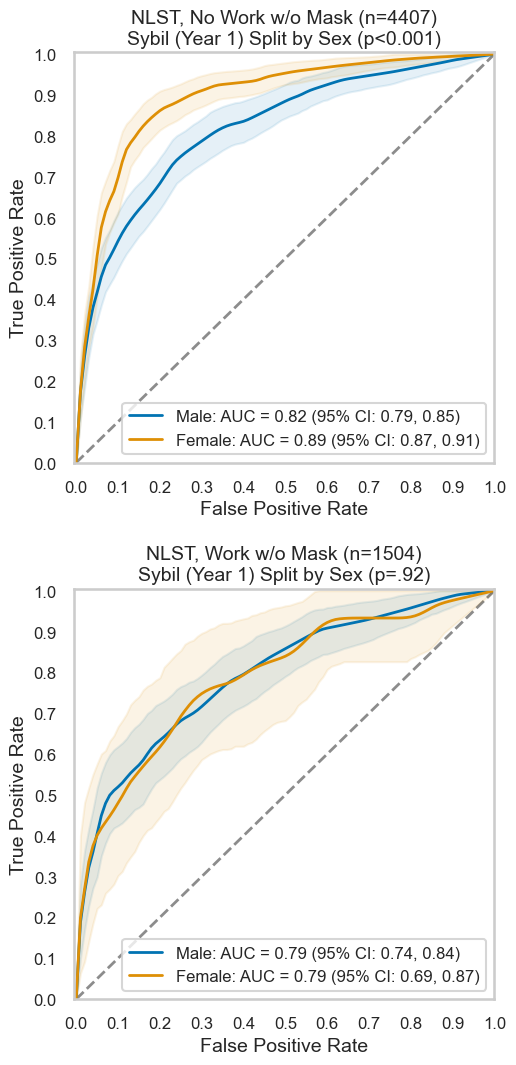

In [62]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Sex',
    'Work w/o Mask',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCgender-WrkNoMask.png"
)

### Race (Venk21)

In [63]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_prev_roc, race_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'WhiteOrBlack',
    NLST_POSSIBLE_CONFOUNDERS,
    race_roc,
    'Venkadesh21',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(race_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceIsolationPlusROC.tex",
    hrules=True, label='tab:raceIsolationPlusROC', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between White and Black patients, and the ROC AUC scores of the Venkadesh model between these racial groups isolating for them.'))

race_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:527: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

White                                  Black       \
                              Mal   Ben Total %              AUROC   Mal  Ben   
Confounder           Subset                                                     
Cigarettes per Day   ≤ 25     246  2610    51.7  0.88 (0.86, 0.90)    20  127   
                     > 25     284  2383    48.3  0.90 (0.89, 0.92)     8   33   
Pack-Years           > 55     281  2116    43.4  0.90 (0.88, 0.91)     5   35   
                     ≤ 55     249  2877    56.6  0.88 (0.86, 0.90)    23  125   
Hypertension Diag.   True     196  1617    32.8  0.87 (0.84, 0.90)    16   86   
                     False    329  3373    67.0  0.90 (0.89, 0.92)    12   74   
Current Smoker       False    247  2542    50.5  0.89 (0.87, 0.91)    11   48   
                     True     283  2451    49.5  0.89 (0.87, 0.91)    17  112   
Smoked Pipe          True     132  1127    22.8  0.90 (0.87, 0.92)     5   12   
                     False    397  3837    76.7  0.89 (0.87, 0.91)    23  145   
Sex                  Female   218  2084    41.7  0.89 (0.87, 0.91)    15   88   
                     Male     312  2909    58.3  0.89 (0.87, 0.91)    13   72   
Diabetes Diag.       True      50   412     8.4  0.90 (0.86, 0.94)     4   31   
                     False    480  4578    91.6  0.89 (0.88, 0.90)    24  129   
Height               > 68     248  2389    47.7  0.89 (0.87, 0.91)    11   60   
                     ≤ 68     282  2604    52.3  0.89 (0.87, 0.91)    17  100   
Work - Farming       True      45   635    12.3  0.90 (0.85, 0.94)     2    4   
                     False    485  4358    87.7  0.89 (0.88, 0.91)    26  156   
Age at Smoking Onset > 16     210  2258    44.7  0.90 (0.87, 0.92)    18   81   
                     ≤ 16     320  2735    55.3  0.89 (0.87, 0.91)    10   79   

                                                          p  
                            Total %              AUROC       
Confounder           Subset                                  
Cigarettes per Day   ≤ 25      78.2  0.77 (0.67, 0.87)  .08  
                     > 25      21.8  0.94 (0.85, 1.00)  .50  
Pack-Years           > 55      21.3  0.93 (0.83, 1.00)  .63  
                     ≤ 55      78.7  0.79 (0.69, 0.88)  .10  
Hypertension Diag.   True      54.3  0.73 (0.61, 0.85)  .04  
                     False     45.7  0.93 (0.87, 0.98)  .60  
Current Smoker       False     31.4  0.88 (0.77, 0.96)  .80  
                     True      68.6  0.76 (0.62, 0.88)  .05  
Smoked Pipe          True       9.0  0.93 (0.77, 1.00)  .75  
                     False     89.4  0.80 (0.70, 0.89)  .11  
Sex                  Female    54.8  0.84 (0.75, 0.92)  .40  
                     Male      45.2  0.81 (0.66, 0.93)  .24  
Diabetes Diag.       True      18.6  0.67 (0.32, 1.00)  .11  
                     False     81.4  0.83 (0.74, 0.91)  .26  
Height               > 68      37.8  0.78 (0.61, 0.93)  .19  
                     ≤ 68      62.2  0.84 (0.76, 0.92)  .36  
Work - Farming       True       3.2  0.99 (1.00, 1.00)  .05  
                     False     96.8  0.81 (0.71, 0.88)  .09  
Age at Smoking Onset > 16      52.7  0.78 (0.66, 0.89)  .07  
                     ≤ 16      47.3  0.88 (0.80, 0.95)  .90

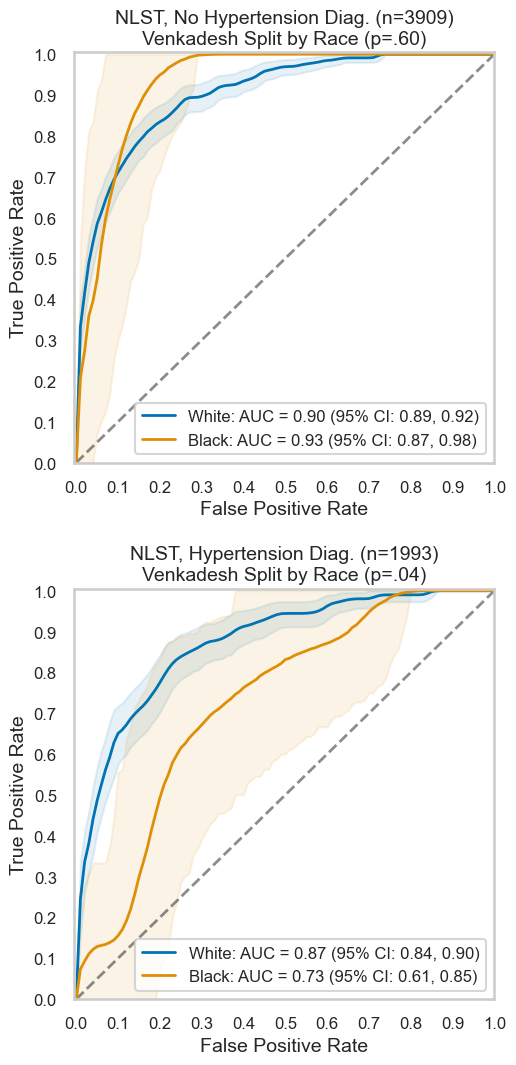

In [64]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Race',
    'Hypertension Diag.',
    models={'Venkadesh': 'DL_cal'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/venkROCrace-Hypertension.png"
)

In [65]:
# race_dehaas_roc, race_topn_confounders = output.prevalence_plus_isolated_roc(
#     nlst_5911_v2,
#     'WhiteOrBlack',
#     NLST_POSSIBLE_CONFOUNDERS,
#     race_roc,
#     'De Haas Local',
#     topn=TOP_N_CONFOUNDERS,
#     result_prec=TABLE_SCORE_PRECISION,
# )
# race_dehaas_roc

### BMI (Sybil)

In [66]:
bmi_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_prev_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROC.tex",
    hrules=True, label='tab:bmiIsolationPlusROC', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI patients, and the ROC AUC scores of the Sybil (Year 1) model between BMI groups isolating for them.'))

bmi_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %              AUROC  Mal   
Confounder             Subset                                              
Weight                 ≤ 180   199  1600    94.7  0.81 (0.78, 0.84)  135   
                       > 180    10    90     5.3  0.93 (0.83, 0.99)  237   
Current Smoker         True    135  1048    62.3  0.81 (0.77, 0.86)  179   
                       False    74   642    37.7  0.82 (0.76, 0.87)  193   
Sex                    Male     92   811    47.6  0.76 (0.70, 0.82)  245   
                       Female  117   879    52.4  0.85 (0.81, 0.89)  127   
Emphysema in Scan      True    103   789    47.0  0.78 (0.73, 0.83)  161   
                       False   106   901    53.0  0.84 (0.79, 0.89)  211   
Hypertension Diag.     False   143  1292    75.6  0.82 (0.78, 0.85)  209   
                       True     62   397    24.2  0.80 (0.73, 0.86)  161   
Height                 > 68     71   680    39.5  0.77 (0.70, 0.83)  196   
                       ≤ 68    138  1010    60.5  0.84 (0.81, 0.88)  176   
Total Years of Smoking ≤ 40     67   707    40.8  0.85 (0.80, 0.90)  124   
                       > 40    142   983    59.2  0.79 (0.75, 0.84)  248   
Smoked Pipe            False   174  1403    83.0  0.83 (0.80, 0.87)  262   
                       True     34   280    16.5  0.74 (0.63, 0.84)  109   
Diabetes Diag.         True      6    62     3.6  0.99 (1.00, 1.00)   51   
                       False   202  1625    96.2  0.81 (0.77, 0.84)  321   
Smoked Cigars          True     27   238    14.0  0.70 (0.59, 0.81)   82   
                       False   181  1446    85.7  0.83 (0.80, 0.87)  289   

                                                                     p  
                                Ben Total %              AUROC          
Confounder             Subset                                           
Weight                 ≤ 180   1161    32.3  0.89 (0.86, 0.92)    .002  
                       > 180   2479    67.7  0.84 (0.81, 0.87)     .12  
Current Smoker         True    1619    44.8  0.86 (0.84, 0.89)     .07  
                       False   2021    55.2  0.85 (0.82, 0.88)     .30  
Sex                    Male    2293    63.3  0.83 (0.80, 0.86)     .03  
                       Female  1347    36.7  0.90 (0.87, 0.93)     .11  
Emphysema in Scan      True    1103    31.5  0.81 (0.77, 0.85)     .44  
                       False   2537    68.5  0.88 (0.86, 0.91)     .10  
Hypertension Diag.     False   2265    61.7  0.88 (0.85, 0.90)     .02  
                       True    1373    38.2  0.82 (0.79, 0.85)     .55  
Height                 > 68    1820    50.2  0.82 (0.78, 0.85)     .19  
                       ≤ 68    1820    49.8  0.89 (0.87, 0.92)     .04  
Total Years of Smoking ≤ 40    1858    49.4  0.84 (0.80, 0.88)     .69  
                       > 40    1782    50.6  0.86 (0.84, 0.88)    .009  
Smoked Pipe            False   2736    74.7  0.86 (0.84, 0.89)     .15  
                       True     878    24.6  0.83 (0.79, 0.87)     .09  
Diabetes Diag.         True     426    11.9  0.82 (0.75, 0.88)  < .001  
                       False   3214    88.1  0.86 (0.84, 0.88)     .01  
Smoked Cigars          True     801    22.0  0.83 (0.79, 0.88)     .02  
                       False   2822    77.5  0.86 (0.83, 0.89)     .23

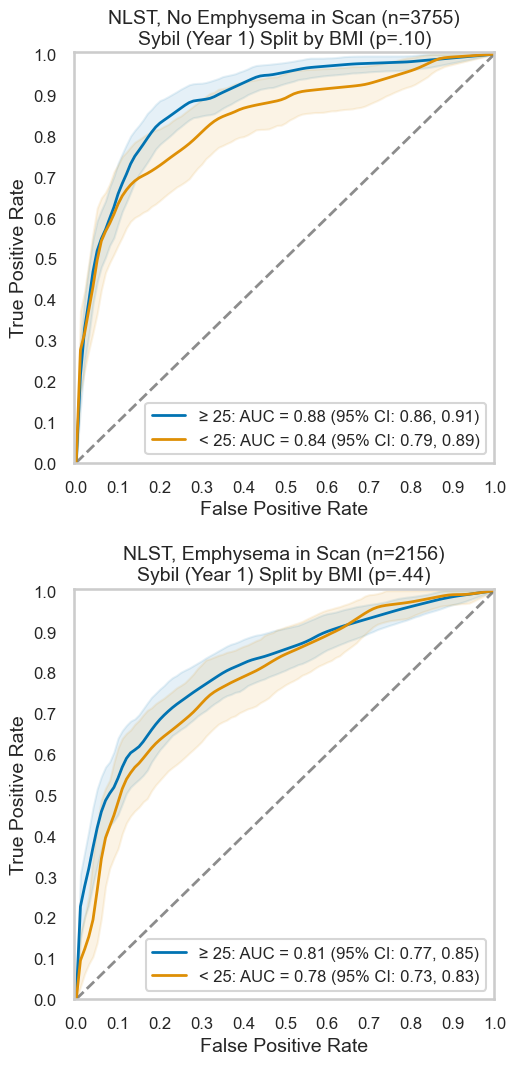

In [67]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'BMI',
    'Emphysema in Scan',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCbmi-Emphysema.png"
)

### BMI (PanCan2b)

In [68]:
bmi_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_pancan_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'PanCan2b',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_pancan_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROCpancan.tex",
    hrules=True, label='tab:bmiIsolationPlusROCpancan', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI patients, and the ROC AUC scores of the PanCan2b model between BMI groups isolating for them.'))


bmi_pancan_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %              AUROC  Mal   
Confounder             Subset                                              
Weight                 ≤ 180   199  1600    94.7  0.73 (0.69, 0.76)  135   
                       > 180    10    90     5.3  0.85 (0.68, 0.99)  237   
Current Smoker         True    135  1048    62.3  0.72 (0.67, 0.77)  179   
                       False    74   642    37.7  0.76 (0.70, 0.82)  193   
Sex                    Male     92   811    47.6  0.73 (0.67, 0.78)  245   
                       Female  117   879    52.4  0.74 (0.69, 0.79)  127   
Emphysema in Scan      True    103   789    47.0  0.68 (0.62, 0.73)  161   
                       False   106   901    53.0  0.78 (0.74, 0.83)  211   
Hypertension Diag.     False   143  1292    75.6  0.74 (0.70, 0.78)  209   
                       True     62   397    24.2  0.70 (0.63, 0.77)  161   
Height                 > 68     71   680    39.5  0.70 (0.64, 0.77)  196   
                       ≤ 68    138  1010    60.5  0.75 (0.71, 0.79)  176   
Total Years of Smoking ≤ 40     67   707    40.8  0.80 (0.74, 0.86)  124   
                       > 40    142   983    59.2  0.69 (0.64, 0.74)  248   
Smoked Pipe            False   174  1403    83.0  0.73 (0.69, 0.77)  262   
                       True     34   280    16.5  0.72 (0.63, 0.81)  109   
Diabetes Diag.         True      6    62     3.6  0.96 (0.91, 1.00)   51   
                       False   202  1625    96.2  0.72 (0.69, 0.76)  321   
Smoked Cigars          True     27   238    14.0  0.66 (0.55, 0.77)   82   
                       False   181  1446    85.7  0.74 (0.70, 0.78)  289   

                                                                     p  
                                Ben Total %              AUROC          
Confounder             Subset                                           
Weight                 ≤ 180   1161    32.3  0.82 (0.79, 0.85)  < .001  
                       > 180   2479    67.7  0.80 (0.77, 0.83)     .46  
Current Smoker         True    1619    44.8  0.81 (0.78, 0.84)    .002  
                       False   2021    55.2  0.80 (0.77, 0.83)     .24  
Sex                    Male    2293    63.3  0.81 (0.79, 0.84)     .01  
                       Female  1347    36.7  0.81 (0.78, 0.85)     .02  
Emphysema in Scan      True    1103    31.5  0.80 (0.76, 0.83)  < .001  
                       False   2537    68.5  0.81 (0.78, 0.83)     .43  
Hypertension Diag.     False   2265    61.7  0.82 (0.80, 0.85)    .005  
                       True    1373    38.2  0.78 (0.74, 0.82)     .05  
Height                 > 68    1820    50.2  0.81 (0.78, 0.84)    .004  
                       ≤ 68    1820    49.8  0.81 (0.78, 0.84)     .05  
Total Years of Smoking ≤ 40    1858    49.4  0.82 (0.79, 0.85)     .56  
                       > 40    1782    50.6  0.79 (0.76, 0.82)  < .001  
Smoked Pipe            False   2736    74.7  0.81 (0.79, 0.84)    .002  
                       True     878    24.6  0.80 (0.76, 0.84)     .16  
Diabetes Diag.         True     426    11.9  0.85 (0.80, 0.90)     .06  
                       False   3214    88.1  0.80 (0.78, 0.83)    .001  
Smoked Cigars          True     801    22.0  0.83 (0.79, 0.87)    .008  
                       False   2822    77.5  0.80 (0.78, 0.83)     .01

### Age

In [69]:
# prev_by_age_cat, prev_by_age_num = output.confounders_by_attribute(nlst_5911_v2, 'Age > 61', NLST_POSSIBLE_CONFOUNDERS)
age_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-age-by-factors-nlst-5911.csv', index_col=0)
age_pancan_roc, age_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Age > 61',
    NLST_POSSIBLE_CONFOUNDERS,
    age_roc,
    'PanCan2b',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(age_pancan_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/ageIsolationPlusROC.tex",
    hrules=True, label='tab:ageIsolationPlusROCpancan', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between participants above and below 61 years old, and the AUROC scores of the PanCan2b model between these groups isolating for them.'))

age_pancan_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:527: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

≤ 61                                  > 61  \
                                Mal   Ben Total %              AUROC  Mal   
Confounder              Subset                                              
Total Years of Smoking  > 40     98   770    33.6  0.77 (0.72, 0.81)  292   
                        ≤ 40    125  1593    66.4  0.83 (0.79, 0.86)   66   
Current Smoker          False    95  1011    42.8  0.83 (0.79, 0.86)  172   
                        True    128  1352    57.2  0.79 (0.75, 0.83)  186   
Hypertension Diag.      False   150  1677    70.6  0.82 (0.78, 0.85)  202   
                        True     72   686    29.3  0.79 (0.72, 0.84)  151   
Diameter (mm)           ≤ 6      23  1026    40.6  0.64 (0.52, 0.77)   33   
                        > 6     200  1337    59.4  0.76 (0.72, 0.79)  325   
Age at Smoking Onset    > 16     88   971    41.0  0.82 (0.77, 0.86)  146   
                        ≤ 16    135  1392    59.0  0.80 (0.76, 0.84)  212   
Emphysema in Scan       False   131  1610    67.3  0.82 (0.78, 0.86)  186   
                        True     92   753    32.7  0.77 (0.72, 0.82)  172   
Heart Disease or Attack False   196  2127    89.8  0.81 (0.78, 0.84)  296   
                        True     26   231     9.9  0.73 (0.63, 0.83)   61   
Pack-Years              ≤ 55    107  1467    60.9  0.83 (0.78, 0.86)  178   
                        > 55    116   896    39.1  0.78 (0.73, 0.82)  180   
Emphysema Diag.         False   190  2199    92.4  0.80 (0.77, 0.83)  307   
                        True     32   163     7.5  0.81 (0.73, 0.87)   50   
Cigarettes per Day      > 25    129  1171    50.3  0.81 (0.77, 0.85)  172   
                        ≤ 25     94  1192    49.7  0.80 (0.76, 0.84)  186   

                                                                   p  
                                 Ben Total %              AUROC       
Confounder              Subset                                        
Total Years of Smoking  > 40    1995    68.8  0.75 (0.72, 0.78)  .61  
                        ≤ 40     972    31.2  0.80 (0.74, 0.85)  .44  
Current Smoker          False   1652    54.9  0.77 (0.74, 0.81)  .10  
                        True    1315    45.1  0.75 (0.72, 0.78)  .21  
Hypertension Diag.      False   1880    62.6  0.78 (0.75, 0.81)  .16  
                        True    1084    37.1  0.74 (0.70, 0.78)  .26  
Diameter (mm)           ≤ 6     1080    33.5  0.64 (0.55, 0.72)  .91  
                        > 6     1887    66.5  0.71 (0.68, 0.74)  .04  
Age at Smoking Onset    > 16    1450    48.0  0.80 (0.77, 0.84)  .65  
                        ≤ 16    1517    52.0  0.73 (0.70, 0.77)  .03  
Emphysema in Scan       False   1828    60.6  0.78 (0.75, 0.81)  .15  
                        True    1139    39.4  0.73 (0.70, 0.77)  .27  
Heart Disease or Attack False   2468    83.1  0.76 (0.73, 0.78)  .01  
                        True     484    16.4  0.79 (0.74, 0.84)  .34  
Pack-Years              ≤ 55    1638    54.6  0.77 (0.74, 0.80)  .08  
                        > 55    1329    45.4  0.76 (0.72, 0.79)  .46  
Emphysema Diag.         False   2569    86.5  0.77 (0.75, 0.80)  .20  
                        True     390    13.2  0.71 (0.63, 0.77)  .09  
Cigarettes per Day      > 25    1320    44.9  0.77 (0.73, 0.80)  .18  
                        ≤ 25    1647    55.1  0.76 (0.73, 0.80)  .23

## Thresholds, isolating for confounders

### Gender

In [70]:
gender_pairwise_comps = None

In [71]:
gender_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
gender_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                   Male             Female   
Confounder         Subset                                                    
Height             > 68               0.52 (0.46, 0.59)  0.60 (0.29, 0.92)   
                   ≤ 68               0.55 (0.45, 0.67)  0.66 (0.60, 0.72)   
Weight             > 180              0.56 (0.49, 0.62)  0.64 (0.47, 0.80)   
                   ≤ 180              0.48 (0.39, 0.56)  0.66 (0.59, 0.72)   
Smoked Pipe        False              0.56 (0.49, 0.63)  0.65 (0.59, 0.71)   
                   True               0.49 (0.40, 0.57)  1.00 (1.00, 1.00)   
Smoked Cigars      False              0.56 (0.50, 0.62)  0.65 (0.59, 0.71)   
                   True               0.45 (0.36, 0.54)  0.86 (0.50, 1.00)   
Work w/o Mask      False              0.53 (0.46, 0.60)  0.68 (0.62, 0.75)   
                   True               0.52 (0.43, 0.61)  0.47 (0.30, 0.65)   
Pack-Years         > 55               0.54 (0.47, 0.60)  0.73 (0.64, 0.82)   
                   ≤ 55               0.52 (0.44, 0.60)  0.60 (0.52, 0.69)   
BMI                < 25               0.50 (0.40, 0.60)  0.66 (0.58, 0.74)   
                   ≥ 25               0.54 (0.48, 0.60)  0.65 (0.56, 0.74)   
Cigarettes per Day > 25               0.54 (0.47, 0.61)  0.74 (0.65, 0.82)   
                   ≤ 25               0.51 (0.43, 0.60)  0.59 (0.51, 0.67)   
Lived w/ Smoker    False              0.51 (0.35, 0.67)  0.57 (0.35, 0.79)   
                   True               0.53 (0.47, 0.59)  0.67 (0.60, 0.73)   
Pneumonia Diag.    False              0.56 (0.50, 0.61)  0.68 (0.61, 0.75)   
                   True               0.40 (0.28, 0.53)  0.64 (0.54, 0.75)   

                              Specificity (90% Sensitivity)  \
                           CI                          Male   
Confounder         Subset                                     
Height             > 68                   0.45 (0.43, 0.47)   
                   ≤ 68                   0.49 (0.46, 0.53)   
Weight             > 180                  0.48 (0.46, 0.51)   
                   ≤ 180   **             0.42 (0.39, 0.45)   
Smoked Pipe        False    *             0.46 (0.44, 0.48)   
                   True    **             0.47 (0.44, 0.50)   
Smoked Cigars      False    *             0.46 (0.43, 0.48)   
                   True     *             0.48 (0.45, 0.51)   
Work w/o Mask      False   **             0.48 (0.46, 0.50)   
                   True                   0.43 (0.40, 0.46)   
Pack-Years         > 55    **             0.43 (0.41, 0.46)   
                   ≤ 55     *             0.49 (0.47, 0.52)   
BMI                < 25     *             0.41 (0.37, 0.44)   
                   ≥ 25     *             0.48 (0.46, 0.50)   
Cigarettes per Day > 25    **             0.45 (0.43, 0.48)   
                   ≤ 25                   0.48 (0.45, 0.50)   
Lived w/ Smoker    False                  0.46 (0.42, 0.50)   
                   True    **             0.46 (0.44, 0.48)   
Pneumonia Diag.    False    *             0.49 (0.47, 0.51)   
                   True    **             0.35 (0.31, 0.39)   

                                                  
                                      Female  CI  
Confounder         Subset                         
Height             > 68    0.47 (0.39, 0.56)      
                   ≤ 68    0.57 (0.55, 0.59)  **  
Weight             > 180   0.63 (0.59, 0.67)  **  
                   ≤ 180   0.54 (0.52, 0.56)  **  
Smoked Pipe        False   0.56 (0.54, 0.58)  **  
                   True    0.47 (0.33, 0.62)      
Smoked Cigars      False   0.56 (0.53, 0.58)  **  
                   True    0.67 (0.56, 0.77)  **  
Work w/o Mask      False   0.57 (0.55, 0.59)  **  
                   True    0.52 (0.46, 0.57)  **  
Pack-Years         > 55    0.54 (0.50, 0.58)  **  
                   ≤ 55    0.57 (0.55, 0.60)  **  
BMI             

In [72]:
print(gender_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderTPRandTNRisolated.tex",
    hrules=True, label='tab:genderTPRandTNRisolated', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% CIs) for the Sybil (Year 1) model between men and women, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between genders. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### Gender (PanCan2b)

In [73]:
pancan_gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
pancan_gender_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                   Male             Female   
Confounder         Subset                                                    
Height             > 68               0.33 (0.27, 0.39)  0.60 (0.29, 0.91)   
                   ≤ 68               0.31 (0.21, 0.43)  0.47 (0.40, 0.53)   
Weight             > 180              0.35 (0.28, 0.41)  0.36 (0.20, 0.52)   
                   ≤ 180              0.29 (0.22, 0.38)  0.49 (0.42, 0.56)   
Smoked Pipe        False              0.32 (0.25, 0.39)  0.47 (0.41, 0.53)   
                   True               0.33 (0.25, 0.41)  0.60 (0.00, 1.00)   
Smoked Cigars      False              0.33 (0.27, 0.40)  0.47 (0.41, 0.53)   
                   True               0.30 (0.22, 0.40)  0.57 (0.17, 1.00)   
Work w/o Mask      False              0.33 (0.26, 0.39)  0.48 (0.41, 0.54)   
                   True               0.32 (0.24, 0.41)  0.43 (0.25, 0.61)   
Pack-Years         > 55               0.30 (0.24, 0.37)  0.50 (0.40, 0.60)   
                   ≤ 55               0.36 (0.29, 0.44)  0.45 (0.37, 0.53)   
BMI                < 25               0.34 (0.24, 0.44)  0.47 (0.38, 0.56)   
                   ≥ 25               0.32 (0.27, 0.38)  0.47 (0.38, 0.56)   
Cigarettes per Day > 25               0.31 (0.25, 0.38)  0.47 (0.37, 0.56)   
                   ≤ 25               0.35 (0.27, 0.42)  0.47 (0.38, 0.56)   
Lived w/ Smoker    False              0.35 (0.21, 0.50)  0.33 (0.14, 0.53)   
                   True               0.32 (0.27, 0.37)  0.49 (0.42, 0.55)   
Pneumonia Diag.    False              0.35 (0.29, 0.40)  0.45 (0.37, 0.53)   
                   True               0.22 (0.12, 0.33)  0.51 (0.40, 0.62)   

                              Specificity (90% Sensitivity)  \
                           CI                          Male   
Confounder         Subset                                     
Height             > 68                   0.49 (0.47, 0.51)   
                   ≤ 68     *             0.53 (0.49, 0.56)   
Weight             > 180                  0.52 (0.50, 0.54)   
                   ≤ 180   **             0.46 (0.43, 0.49)   
Smoked Pipe        False   **             0.51 (0.49, 0.53)   
                   True                   0.49 (0.46, 0.52)   
Smoked Cigars      False   **             0.50 (0.48, 0.53)   
                   True                   0.50 (0.47, 0.53)   
Work w/o Mask      False   **             0.51 (0.49, 0.53)   
                   True                   0.49 (0.46, 0.51)   
Pack-Years         > 55    **             0.48 (0.45, 0.50)   
                   ≤ 55     *             0.52 (0.50, 0.55)   
BMI                < 25     *             0.45 (0.42, 0.49)   
                   ≥ 25    **             0.52 (0.50, 0.54)   
Cigarettes per Day > 25     *             0.49 (0.46, 0.51)   
                   ≤ 25     *             0.51 (0.49, 0.54)   
Lived w/ Smoker    False                  0.50 (0.46, 0.54)   
                   True    **             0.50 (0.48, 0.52)   
Pneumonia Diag.    False    *             0.52 (0.50, 0.54)   
                   True    **             0.44 (0.40, 0.48)   

                                                  
                                      Female  CI  
Confounder         Subset                         
Height             > 68    0.28 (0.21, 0.36)  **  
                   ≤ 68    0.37 (0.36, 0.39)  **  
Weight             > 180   0.38 (0.33, 0.42)  **  
                   ≤ 180   0.37 (0.34, 0.39)  **  
Smoked Pipe        False   0.37 (0.35, 0.39)  **  
                   True    0.33 (0.19, 0.49)   *  
Smoked Cigars      False   0.36 (0.34, 0.38)  **  
                   True    0.45 (0.33, 0.56)      
Work w/o Mask      False   0.37 (0.35, 0.39)  **  
                   True    0.36 (0.30, 0.41)  **  
Pack-Years         > 55    0.37 (0.33, 0.40)  **  
                   ≤ 55    0.37 (0.35, 0.39)  **  
BMI             

### Race

In [74]:
race_pairwise_comps = None

In [75]:
race_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
race_tpr_tnr, race_pairwise_comps = output.threshold_isolation_pairwise(
    race_isolations, "WhiteOrBlack", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=race_topn_confounders, 
    pairwise_comps=race_pairwise_comps)
race_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                    White              Black   
Confounder           Subset                                                    
Cigarettes per Day   > 25               0.72 (0.66, 0.77)  0.75 (0.40, 1.00)   
                     ≤ 25               0.65 (0.60, 0.71)  0.25 (0.07, 0.44)   
Pack-Years           > 55               0.71 (0.65, 0.76)  0.60 (0.00, 1.00)   
                     ≤ 55               0.67 (0.61, 0.73)  0.35 (0.16, 0.55)   
Hypertension Diag.   False              0.71 (0.66, 0.76)  0.67 (0.36, 0.92)   
                     True               0.65 (0.58, 0.72)  0.19 (0.00, 0.40)   
Current Smoker       False              0.67 (0.60, 0.72)  0.36 (0.10, 0.67)   
                     True               0.71 (0.65, 0.76)  0.41 (0.17, 0.67)   
Smoked Pipe          False              0.70 (0.65, 0.74)  0.43 (0.23, 0.65)   
                     True               0.65 (0.57, 0.72)  0.20 (0.00, 0.67)   
Sex                  Female             0.72 (0.66, 0.78)  0.40 (0.17, 0.67)   
                     Male               0.66 (0.61, 0.71)  0.38 (0.12, 0.67)   
Diabetes Diag.       False              0.69 (0.64, 0.73)  0.38 (0.18, 0.57)   
                     True               0.72 (0.59, 0.84)  0.50 (0.00, 1.00)   
Height               > 68               0.66 (0.60, 0.72)  0.36 (0.10, 0.70)   
                     ≤ 68               0.71 (0.66, 0.76)  0.41 (0.17, 0.67)   
Work - Farming       False              0.69 (0.64, 0.73)  0.38 (0.19, 0.57)   
                     True               0.71 (0.56, 0.84)  0.50 (0.00, 1.00)   
Age at Smoking Onset > 16               0.73 (0.67, 0.79)  0.39 (0.17, 0.63)   
                     ≤ 16               0.66 (0.61, 0.72)  0.40 (0.12, 0.71)   

                                Specificity (90% Sensitivity)  \
                             CI                         White   
Confounder           Subset                                     
Cigarettes per Day   > 25                   0.66 (0.64, 0.68)   
                     ≤ 25    **             0.66 (0.64, 0.68)   
Pack-Years           > 55                   0.65 (0.63, 0.67)   
                     ≤ 55    **             0.67 (0.65, 0.69)   
Hypertension Diag.   False                  0.67 (0.65, 0.69)   
                     True    **             0.64 (0.62, 0.66)   
Current Smoker       False    *             0.67 (0.65, 0.68)   
                     True     *             0.65 (0.63, 0.67)   
Smoked Pipe          False   **             0.66 (0.65, 0.68)   
                     True                   0.65 (0.63, 0.68)   
Sex                  Female   *             0.68 (0.66, 0.70)   
                     Male                   0.65 (0.63, 0.66)   
Diabetes Diag.       False   **             0.66 (0.65, 0.67)   
                     True                   0.66 (0.61, 0.70)   
Height               > 68                   0.64 (0.62, 0.66)   
                     ≤ 68     *             0.68 (0.66, 0.70)   
Work - Farming       False   **             0.66 (0.65, 0.68)   
                     True                   0.64 (0.61, 0.68)   
Age at Smoking Onset > 16    **             0.67 (0.65, 0.69)   
                     ≤ 16                   0.65 (0.64, 0.67)   

                                                    
                                         Black  CI  
Confounder           Subset                         
Cigarettes per Day   > 25    0.70 (0.53, 0.85)      
                     ≤ 25    0.74 (0.67, 0.81)   *  
Pack-Years           > 55    0.71 (0.54, 0.85)      
                     ≤ 55    0.74 (0.66, 0.82)      
Hypertension Diag.   False   0.72 (0.61, 0.82)      
                     True    0.74 (0.65, 0.84)   *  
Current Smoker       False   0.77 (0.65, 0.89)      
                     True    0.71 (0.63, 0.80)      
Smoked Pipe          False   0.71 (0.64, 0.78)      
                     True    0.92 (0.73, 1.00)  **  
Se

In [76]:
print(race_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceTPRandTNRisolated.tex",
    hrules=True, label='tab:raceTPRandTNRisolated', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% CIs) for the Venkadesh model between between White and Black patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [77]:
# race_dehaas_local_tpr_tnr, race_pairwise_comps = output.threshold_isolation_pairwise(
#     race_isolations, "WhiteOrBlack", "De Haas Local", 
#     nlst_5911_policies, 
#     topn_confs=race_topn_confounders, 
#     pairwise_comps=race_pairwise_comps)
# race_dehaas_local_tpr_tnr

### BMI

In [78]:
bmi_pairwise_comps = None

In [79]:
bmi_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)
bmi_tpr_tnr

Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.56 (0.50, 0.62)   
                       ≤ 180              0.61 (0.52, 0.69)   
Current Smoker         False              0.57 (0.50, 0.64)   
                       True               0.59 (0.52, 0.66)   
Sex                    Female             0.65 (0.57, 0.74)   
                       Male               0.54 (0.48, 0.60)   
Emphysema in Scan      False              0.60 (0.54, 0.66)   
                       True               0.55 (0.47, 0.63)   
Hypertension Diag.     False              0.63 (0.57, 0.70)   
                       True               0.51 (0.43, 0.58)   
Height                 > 68               0.54 (0.46, 0.61)   
                       ≤ 68               0.62 (0.55, 0.70)   
Total Years of Smoking > 40               0.59 (0.53, 0.65)   
                       ≤ 40               0.56 (0.47, 0.64)   
Smoked Pipe            False              0.60 (0.54, 0.67)   
                       True               0.51 (0.42, 0.61)   
Diabetes Diag.         False              0.57 (0.52, 0.63)   
                       True               0.61 (0.47, 0.72)   
Smoked Cigars          False              0.60 (0.54, 0.66)   
                       True               0.50 (0.39, 0.60)   

                                                      \
                                            < 25  CI   
Confounder             Subset                          
Weight                 > 180   0.80 (0.50, 1.00)       
                       ≤ 180   0.58 (0.51, 0.64)       
Current Smoker         False   0.57 (0.45, 0.69)       
                       True    0.60 (0.52, 0.68)       
Sex                    Female  0.66 (0.57, 0.75)       
                       Male    0.50 (0.40, 0.61)       
Emphysema in Scan      False   0.60 (0.50, 0.70)       
                       True    0.57 (0.48, 0.67)       
Hypertension Diag.     False   0.56 (0.49, 0.64)       
                       True    0.65 (0.53, 0.77)   *   
Height                 > 68    0.49 (0.38, 0.61)       
                       ≤ 68    0.64 (0.55, 0.72)       
Total Years of Smoking > 40    0.59 (0.52, 0.67)       
                       ≤ 40    0.58 (0.47, 0.70)       
Smoked Pipe            False   0.61 (0.55, 0.69)       
                       True    0.47 (0.30, 0.65)       
Diabetes Diag.         False   0.58 (0.51, 0.65)       
                       True    1.00 (1.00, 1.00)  **   
Smoked Cigars          False   0.62 (0.55, 0.68)       
                       True    0.41 (0.22, 0.60)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.51 (0.49, 0.53)   
                       ≤ 180              0.55 (0.52, 0.58)   
Current Smoker         False              0.52 (0.50, 0.55)   
                       True               0.53 (0.50, 0.55)   
Sex                    Female             0.60 (0.57, 0.62)   
                       Male               0.48 (0.46, 0.50)   
Emphysema in Scan      False              0.56 (0.54, 0.58)   
                       True               0.44 (0.42, 0.47)   
Hypertension Diag.     False              0.55 (0.53, 0.57)   
                       True               0.48 (0.46, 0.51)   
Height                 > 68               0.48 (0.45, 0.50)   
                       ≤ 68               0.57 (0.55, 0.59)   
Total Years of Smoking > 40               0.49 (0.46, 0.51)   
                       ≤ 40               0.56 (0.54, 0.58)   
Smoked Pipe            False              0.54 (0.52, 0.56)   
                       True               0.49 (0.45, 0.52)   
Diabetes Diag.         False              0.53 (0.51, 0.54)   
                       True    

In [80]:
print(bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolated.tex",
    hrules=True, label='tab:bmiTPRandTNRisolated', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% CIs) for the Sybil (Year 1) model between between high and low BMI patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between these groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### BMI (PanCan2b)

In [81]:
bmi_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_pancan_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)

print(bmi_pancan_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolatedPanCan.tex",
    hrules=True, label='tab:bmiTPRandTNRisolatedPanCan', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% CIs) for the PanCan2b model between between high and low BMI patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between these groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

bmi_pancan_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.34 (0.28, 0.40)   
                       ≤ 180              0.43 (0.34, 0.52)   
Current Smoker         False              0.36 (0.29, 0.43)   
                       True               0.39 (0.32, 0.46)   
Sex                    Female             0.47 (0.39, 0.56)   
                       Male               0.32 (0.27, 0.38)   
Emphysema in Scan      False              0.33 (0.27, 0.39)   
                       True               0.43 (0.35, 0.50)   
Hypertension Diag.     False              0.38 (0.31, 0.45)   
                       True               0.37 (0.30, 0.44)   
Height                 > 68               0.34 (0.28, 0.41)   
                       ≤ 68               0.41 (0.34, 0.48)   
Total Years of Smoking > 40               0.40 (0.33, 0.45)   
                       ≤ 40               0.33 (0.25, 0.42)   
Smoked Pipe            False              0.39 (0.32, 0.45)   
                       True               0.35 (0.26, 0.44)   
Diabetes Diag.         False              0.36 (0.31, 0.41)   
                       True               0.45 (0.31, 0.58)   
Smoked Cigars          False              0.40 (0.34, 0.45)   
                       True               0.29 (0.19, 0.39)   

                                                     \
                                            < 25 CI   
Confounder             Subset                         
Weight                 > 180   0.50 (0.18, 0.83)      
                       ≤ 180   0.41 (0.34, 0.48)      
Current Smoker         False   0.43 (0.32, 0.55)      
                       True    0.40 (0.31, 0.48)      
Sex                    Female  0.47 (0.38, 0.56)      
                       Male    0.34 (0.24, 0.44)      
Emphysema in Scan      False   0.43 (0.35, 0.53)  *   
                       True    0.39 (0.29, 0.49)      
Hypertension Diag.     False   0.44 (0.36, 0.52)      
                       True    0.35 (0.24, 0.48)      
Height                 > 68    0.34 (0.23, 0.45)      
                       ≤ 68    0.45 (0.37, 0.53)      
Total Years of Smoking > 40    0.35 (0.27, 0.43)      
                       ≤ 40    0.54 (0.42, 0.66)  *   
Smoked Pipe            False   0.43 (0.35, 0.50)      
                       True    0.32 (0.17, 0.48)      
Diabetes Diag.         False   0.40 (0.34, 0.47)      
                       True    0.67 (0.25, 1.00)      
Smoked Cigars          False   0.41 (0.34, 0.48)      
                       True    0.41 (0.21, 0.58)      

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.49 (0.47, 0.51)   
                       ≤ 180              0.43 (0.40, 0.46)   
Current Smoker         False              0.46 (0.43, 0.48)   
                       True               0.49 (0.46, 0.51)   
Sex                    Female             0.39 (0.36, 0.41)   
                       Male               0.52 (0.50, 0.54)   
Emphysema in Scan      False              0.50 (0.48, 0.52)   
                       True               0.40 (0.37, 0.43)   
Hypertension Diag.     False              0.49 (0.47, 0.52)   
                       True               0.43 (0.40, 0.46)   
Height                 > 68               0.50 (0.48, 0.53)   
                       ≤ 68               0.44 (0.41, 0.46)   
Total Years of Smoking > 40               0.44 (0.42, 0.47)   
                       ≤ 40               0.50 (0.47, 0.52)   
Smoked Pipe            False              0.46 (0.45, 0.48)   
                       True               0.49 (0.46, 0.53)   
Diabetes Diag.         False              0.47 (0.46, 0.49)   
                       True               0.45 (0.40, 

### BMI (Venk21)

In [82]:
bmi_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_venk_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)

print(bmi_venk_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolatedVenk21.tex",
    hrules=True, label='tab:bmiTPRandTNRisolatedVenk21', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% CIs) for the Venkadesh21 model between between high and low BMI patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between these groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

bmi_venk_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.68 (0.62, 0.74)   
                       ≤ 180              0.67 (0.59, 0.74)   
Current Smoker         False              0.65 (0.58, 0.71)   
                       True               0.71 (0.64, 0.77)   
Sex                    Female             0.68 (0.60, 0.76)   
                       Male               0.68 (0.62, 0.74)   
Emphysema in Scan      False              0.69 (0.63, 0.76)   
                       True               0.66 (0.58, 0.73)   
Hypertension Diag.     False              0.74 (0.68, 0.80)   
                       True               0.60 (0.52, 0.68)   
Height                 > 68               0.67 (0.61, 0.74)   
                       ≤ 68               0.68 (0.61, 0.75)   
Total Years of Smoking > 40               0.70 (0.65, 0.75)   
                       ≤ 40               0.63 (0.55, 0.71)   
Smoked Pipe            False              0.68 (0.62, 0.74)   
                       True               0.67 (0.58, 0.76)   
Diabetes Diag.         False              0.68 (0.62, 0.73)   
                       True               0.69 (0.55, 0.81)   
Smoked Cigars          False              0.70 (0.65, 0.75)   
                       True               0.59 (0.47, 0.69)   

                                                      \
                                            < 25  CI   
Confounder             Subset                          
Weight                 > 180   0.60 (0.29, 0.90)       
                       ≤ 180   0.69 (0.63, 0.76)       
Current Smoker         False   0.70 (0.60, 0.80)       
                       True    0.68 (0.60, 0.76)       
Sex                    Female  0.74 (0.66, 0.83)       
                       Male    0.62 (0.52, 0.72)       
Emphysema in Scan      False   0.65 (0.56, 0.74)       
                       True    0.73 (0.64, 0.81)       
Hypertension Diag.     False   0.69 (0.61, 0.76)       
                       True    0.69 (0.59, 0.81)       
Height                 > 68    0.62 (0.51, 0.73)       
                       ≤ 68    0.72 (0.65, 0.80)       
Total Years of Smoking > 40    0.71 (0.63, 0.78)       
                       ≤ 40    0.64 (0.52, 0.76)       
Smoked Pipe            False   0.71 (0.65, 0.78)       
                       True    0.59 (0.41, 0.74)       
Diabetes Diag.         False   0.68 (0.62, 0.74)       
                       True    1.00 (1.00, 1.00)  **   
Smoked Cigars          False   0.71 (0.64, 0.77)       
                       True    0.59 (0.39, 0.77)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.68 (0.66, 0.70)   
                       ≤ 180              0.69 (0.66, 0.72)   
Current Smoker         False              0.69 (0.67, 0.71)   
                       True               0.68 (0.65, 0.70)   
Sex                    Female             0.70 (0.68, 0.73)   
                       Male               0.67 (0.65, 0.69)   
Emphysema in Scan      False              0.70 (0.68, 0.71)   
                       True               0.65 (0.62, 0.67)   
Hypertension Diag.     False              0.70 (0.68, 0.72)   
                       True               0.66 (0.63, 0.68)   
Height                 > 68               0.67 (0.64, 0.69)   
                       ≤ 68               0.70 (0.68, 0.72)   
Total Years of Smoking > 40               0.66 (0.64, 0.69)   
                       ≤ 40               0.70 (0.68, 0.72)   
Smoked Pipe            False              0.68 (0.67, 0.70)   
                       True               0.68 (0.65, 0.71)   
Diabetes Diag.         False              0.68 (0.67, 0.70)   
                       True    

### Age

In [83]:
age_pairwise_comps = None

In [84]:
age_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-age-by-factors-nlst-5911.csv', index_col=0)
age_pancan_tpr_tnr, age_pairwise_comps = output.threshold_isolation_pairwise(
    age_isolations, "Age > 61", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=age_topn_confounders, 
    pairwise_comps=age_pairwise_comps)

age_pancan_tpr_tnr

Sensitivity (90% Specificity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.38 (0.27, 0.47)   
                        ≤ 40               0.37 (0.29, 0.45)   
Current Smoker          False              0.33 (0.24, 0.42)   
                        True               0.41 (0.32, 0.50)   
Hypertension Diag.      False              0.37 (0.29, 0.44)   
                        True               0.39 (0.27, 0.50)   
Diameter (mm)           > 6                0.41 (0.35, 0.48)   
                        ≤ 6                0.00 (0.00, 0.00)   
Age at Smoking Onset    > 16               0.33 (0.24, 0.43)   
                        ≤ 16               0.40 (0.31, 0.48)   
Emphysema in Scan       False              0.34 (0.27, 0.43)   
                        True               0.41 (0.31, 0.51)   
Heart Disease or Attack False              0.40 (0.33, 0.46)   
                        True               0.19 (0.06, 0.36)   
Pack-Years              > 55               0.34 (0.26, 0.43)   
                        ≤ 55               0.40 (0.32, 0.50)   
Emphysema Diag.         False              0.36 (0.29, 0.43)   
                        True               0.47 (0.30, 0.63)   
Cigarettes per Day      > 25               0.34 (0.25, 0.42)   
                        ≤ 25               0.41 (0.32, 0.51)   

                                                      \
                                             > 61 CI   
Confounder              Subset                         
Total Years of Smoking  > 40    0.38 (0.33, 0.44)      
                        ≤ 40    0.47 (0.35, 0.58)      
Current Smoker          False   0.41 (0.34, 0.48)      
                        True    0.38 (0.31, 0.45)      
Hypertension Diag.      False   0.43 (0.36, 0.50)      
                        True    0.35 (0.27, 0.43)      
Diameter (mm)           > 6     0.44 (0.39, 0.49)      
                        ≤ 6     0.00 (0.00, 0.00)      
Age at Smoking Onset    > 16    0.46 (0.37, 0.54)  *   
                        ≤ 16    0.35 (0.29, 0.43)      
Emphysema in Scan       False   0.38 (0.31, 0.46)      
                        True    0.41 (0.34, 0.49)      
Heart Disease or Attack False   0.38 (0.33, 0.44)      
                        True    0.48 (0.36, 0.60)  *   
Pack-Years              > 55    0.38 (0.31, 0.46)      
                        ≤ 55    0.41 (0.34, 0.48)      
Emphysema Diag.         False   0.40 (0.35, 0.46)      
                        True    0.36 (0.23, 0.50)      
Cigarettes per Day      > 25    0.38 (0.31, 0.45)      
                        ≤ 25    0.41 (0.34, 0.47)      

                               Specificity (90% Sensitivity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.49 (0.45, 0.52)   
                        ≤ 40               0.52 (0.50, 0.55)   
Current Smoker          False              0.50 (0.47, 0.53)   
                        True               0.52 (0.49, 0.54)   
Hypertension Diag.      False              0.53 (0.50, 0.55)   
                        True               0.48 (0.44, 0.52)   
Diameter (mm)           > 6                0.19 (0.17, 0.21)   
                        ≤ 6                0.93 (0.92, 0.95)   
Age at Smoking Onset    > 16               0.51 (0.48, 0.54)   
                        ≤ 16               0.51 (0.49, 0.54)   
Emphysema in Scan       False              0.55 (0.52, 0.57)   
                        True               0.44 (0.40, 0.47)   
Heart Disease or Attack False              0.52 (0.49, 0.54)   
                        True               0.47 (0.41, 0.53)   
Pack-Years              > 55               0.49 (0.46, 0.53)   
                        ≤ 55               0.52 (0.50, 0.55)   
Emphysema Diag.         False              0.52 (0.50

In [85]:
age_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-age-by-factors-nlst-5911.csv', index_col=0)
age_venk_tpr_tnr, age_pairwise_comps = output.threshold_isolation_pairwise(
    age_isolations, "Age > 61", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=age_topn_confounders, 
    pairwise_comps=age_pairwise_comps)
age_venk_tpr_tnr

Sensitivity (90% Specificity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.67 (0.58, 0.77)   
                        ≤ 40               0.62 (0.54, 0.71)   
Current Smoker          False              0.63 (0.53, 0.73)   
                        True               0.66 (0.58, 0.73)   
Hypertension Diag.      False              0.69 (0.61, 0.76)   
                        True               0.57 (0.46, 0.68)   
Diameter (mm)           > 6                0.69 (0.61, 0.74)   
                        ≤ 6                0.30 (0.12, 0.50)   
Age at Smoking Onset    > 16               0.59 (0.48, 0.69)   
                        ≤ 16               0.68 (0.60, 0.76)   
Emphysema in Scan       False              0.63 (0.54, 0.70)   
                        True               0.67 (0.57, 0.77)   
Heart Disease or Attack False              0.65 (0.58, 0.72)   
                        True               0.65 (0.45, 0.83)   
Pack-Years              > 55               0.67 (0.59, 0.76)   
                        ≤ 55               0.62 (0.53, 0.71)   
Emphysema Diag.         False              0.64 (0.57, 0.71)   
                        True               0.69 (0.53, 0.84)   
Cigarettes per Day      > 25               0.71 (0.63, 0.78)   
                        ≤ 25               0.56 (0.47, 0.66)   

                                                      \
                                             > 61 CI   
Confounder              Subset                         
Total Years of Smoking  > 40    0.72 (0.67, 0.77)      
                        ≤ 40    0.65 (0.54, 0.77)      
Current Smoker          False   0.68 (0.61, 0.75)      
                        True    0.73 (0.66, 0.79)      
Hypertension Diag.      False   0.74 (0.67, 0.80)      
                        True    0.66 (0.58, 0.73)      
Diameter (mm)           > 6     0.76 (0.71, 0.80)  *   
                        ≤ 6     0.18 (0.06, 0.32)      
Age at Smoking Onset    > 16    0.77 (0.69, 0.83)  *   
                        ≤ 16    0.66 (0.60, 0.72)      
Emphysema in Scan       False   0.72 (0.65, 0.78)  *   
                        True    0.69 (0.62, 0.76)      
Heart Disease or Attack False   0.69 (0.64, 0.75)      
                        True    0.77 (0.65, 0.87)      
Pack-Years              > 55    0.73 (0.67, 0.80)      
                        ≤ 55    0.67 (0.60, 0.74)      
Emphysema Diag.         False   0.71 (0.66, 0.76)  *   
                        True    0.68 (0.54, 0.82)      
Cigarettes per Day      > 25    0.74 (0.67, 0.80)      
                        ≤ 25    0.67 (0.61, 0.74)  *   

                               Specificity (90% Sensitivity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.68 (0.65, 0.71)   
                        ≤ 40               0.70 (0.68, 0.73)   
Current Smoker          False              0.69 (0.66, 0.72)   
                        True               0.70 (0.68, 0.72)   
Hypertension Diag.      False              0.70 (0.68, 0.72)   
                        True               0.69 (0.66, 0.72)   
Diameter (mm)           > 6                0.54 (0.51, 0.56)   
                        ≤ 6                0.90 (0.88, 0.92)   
Age at Smoking Onset    > 16               0.71 (0.68, 0.74)   
                        ≤ 16               0.68 (0.66, 0.71)   
Emphysema in Scan       False              0.71 (0.69, 0.73)   
                        True               0.66 (0.63, 0.69)   
Heart Disease or Attack False              0.70 (0.68, 0.72)   
                        True               0.61 (0.55, 0.68)   
Pack-Years              > 55               0.67 (0.64, 0.70)   
                        ≤ 55               0.71 (0.69, 0.74)   
Emphysema Diag.         False              0.70 (0.69

In [86]:
age_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-age-by-factors-nlst-5911.csv', index_col=0)
age_sybil_tpr_tnr, age_pairwise_comps = output.threshold_isolation_pairwise(
    age_isolations, "Age > 61", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=age_topn_confounders, 
    pairwise_comps=age_pairwise_comps)
age_sybil_tpr_tnr

Sensitivity (90% Specificity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.56 (0.46, 0.66)   
                        ≤ 40               0.51 (0.43, 0.60)   
Current Smoker          False              0.58 (0.49, 0.68)   
                        True               0.50 (0.42, 0.59)   
Hypertension Diag.      False              0.54 (0.46, 0.62)   
                        True               0.53 (0.42, 0.65)   
Diameter (mm)           > 6                0.58 (0.51, 0.64)   
                        ≤ 6                0.13 (0.00, 0.28)   
Age at Smoking Onset    > 16               0.49 (0.39, 0.59)   
                        ≤ 16               0.56 (0.48, 0.65)   
Emphysema in Scan       False              0.60 (0.52, 0.68)   
                        True               0.43 (0.33, 0.53)   
Heart Disease or Attack False              0.53 (0.46, 0.60)   
                        True               0.62 (0.42, 0.81)   
Pack-Years              > 55               0.53 (0.45, 0.62)   
                        ≤ 55               0.53 (0.44, 0.62)   
Emphysema Diag.         False              0.52 (0.45, 0.59)   
                        True               0.62 (0.45, 0.79)   
Cigarettes per Day      > 25               0.55 (0.46, 0.64)   
                        ≤ 25               0.51 (0.41, 0.61)   

                                                       \
                                             > 61  CI   
Confounder              Subset                          
Total Years of Smoking  > 40    0.60 (0.55, 0.65)       
                        ≤ 40    0.67 (0.54, 0.78)   *   
Current Smoker          False   0.56 (0.49, 0.63)       
                        True    0.66 (0.59, 0.73)   *   
Hypertension Diag.      False   0.65 (0.58, 0.71)   *   
                        True    0.56 (0.48, 0.64)       
Diameter (mm)           > 6     0.66 (0.61, 0.72)   *   
                        ≤ 6     0.09 (0.00, 0.21)       
Age at Smoking Onset    > 16    0.69 (0.61, 0.76)  **   
                        ≤ 16    0.56 (0.49, 0.62)       
Emphysema in Scan       False   0.60 (0.53, 0.67)       
                        True    0.62 (0.55, 0.69)  **   
Heart Disease or Attack False   0.60 (0.54, 0.67)   *   
                        True    0.66 (0.53, 0.78)       
Pack-Years              > 55    0.64 (0.57, 0.71)   *   
                        ≤ 55    0.58 (0.52, 0.65)       
Emphysema Diag.         False   0.60 (0.54, 0.66)   *   
                        True    0.70 (0.56, 0.82)       
Cigarettes per Day      > 25    0.66 (0.59, 0.72)   *   
                        ≤ 25    0.57 (0.51, 0.64)       

                               Specificity (90% Sensitivity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.53 (0.50, 0.56)   
                        ≤ 40               0.59 (0.57, 0.61)   
Current Smoker          False              0.58 (0.55, 0.61)   
                        True               0.56 (0.54, 0.59)   
Hypertension Diag.      False              0.58 (0.56, 0.60)   
                        True               0.54 (0.50, 0.57)   
Diameter (mm)           > 6                0.42 (0.40, 0.45)   
                        ≤ 6                0.76 (0.73, 0.78)   
Age at Smoking Onset    > 16               0.60 (0.57, 0.63)   
                        ≤ 16               0.55 (0.53, 0.58)   
Emphysema in Scan       False              0.60 (0.58, 0.63)   
                        True               0.49 (0.46, 0.53)   
Heart Disease or Attack False              0.58 (0.56, 0.60)   
                        True               0.47 (0.40, 0.53)   
Pack-Years              > 55               0.52 (0.49, 0.55)   
                        ≤ 55               0.60 (0.57, 0.62)   
Emphysema Diag.         False 